# Machine Learning – Proyecto Final

## Clasificación de leads de venta en dataset de clientes bancarios

### Equipo:
- Salomón Ramírez Contla
- Javier De La Rosa Mondragón
- Luis Fernando Merino Nambo


![Leads](credit-cards.jpg)

## Objetivos

Analizar, limpiar y usar el train dataset para identificar clientes con tendencia a adquirur una tarjeta de crédito tomando como features las características del cliente.

Explorar las pistas que nos dan los diferentes modelos y tecnicas de clasificación para entender más cómo se pueden aplicar en este y en casos donde puede aplicar ML.

Poner en práctica los conocimientos adquiridos durante el módulo.


##  Dataset

Credit Card Lead Prediction

https://www.kaggle.com/datasets/shelvigarg/credit-card-buyers

- ~250,000 datos en train set

- ~100,000 datos en test set (sin eqtiquetas)

- 10 Features
    - ID
    - Sexo
    - Edad
    - Región
    - Ocupación
    - Channel code (medio de comunicación para ofrecer la tarjeta)
    - Vintage (meses de historial crediticio)
    - Credit product (el cliente cuenta ya con un producto de crédito)
    - Balance promedio en cuenta
    - Es cliente activo
    


- 1 Columna de target
    - Lead (aceptó la tarjeta de crédito ofecida)

## Retos

- El dataset que utlilzaremos es muy grande, lo cual requiere que encontremos soluciones para trabajar con él y el poder de cómputo requerido puede ser poco accesible para trabajarlo dentro de rangos de tiempo compatibles con otras actividades.
- De inmediato se puede observar que casi todas nuestras variables son categóricas. Para poder utlizarlas será necesario manipular los datos y buscar hiperparámetros adecuados para ellas (valores, distribuciones de probabilidad, etc.)

## Código

In [1]:
# VARIABLES PARA EJECUCIÓN
RESERVE_FOR_TEST = .3 # debido a que no tenemos un test set originalmente reservamos una fraccion para test final
DATA_FRACTION = 1 # parte del train dataset completo de datos a utlizar (para hacer pruebas rápidas])
DATA_TO_USE = 'over' # 'over' | 'sub' | 'orig'  # los datos que se usarán en el entrenamiento final
SMOTE_FRACTION = .75 # parte del dataset sobremuestreado a utlizar ya que SMOTE devuelve muchos más datos que los originales

### Importación de bibliotecas 

In [2]:
# numerical y Dfs
import pandas as pd
import numpy as np

# ML:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2 # selección de features categoricas
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

# statistical
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr

# SMOTE oversamplig
from imblearn.over_sampling import SMOTE

# árboles de decisión
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# imbalanced classes
import imblearn

# visualización de árboles con dtreeviz
from sklearn import tree
#from dtreeviz import model
from dtreeviz.trees import *

# visualización de árboles con graphviz
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

# métricas de rendimiento
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# visualización
import seaborn as sns
from matplotlib import pyplot as plt

# timing operations
import time

# misc
from collections import Counter

In [3]:
# paletas para seaborn
palQualitative = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#f2f2f2']
palPaired = sns.color_palette("Accent")
sns.set()
sns.set_palette( palQualitative )

In [4]:
def printTime(msg='time_now:',hours=1,mins=53):
    '''imprime la hora corregida porque el servidor la tiene mal'''
    current_time = time.localtime()
    new_time = current_time.tm_min - mins
    new_time = new_time % 60
    print(msg, f" {current_time.tm_hour-hours:02d}:{new_time:02d}:{current_time.tm_sec:02d}")

### Lectura de datos

In [5]:
data = pd.read_csv('./data/train data credit card.csv')
print('Full Data size:',data.shape)

Full Data size: (245725, 11)


In [6]:
# test data (como no tenemos la etiquetas, evaluaremos nuestros modelos con subsets para test)
#TESTDATA = pd.read_csv('./data/test data credit card.csv')
#TESTDATA.shape

In [7]:
data.head()

ID  Gender  Age Region_Code     Occupation Channel_Code  Vintage  \
0  NNVBBKZB  Female   73       RG268          Other           X3       43   
1  IDD62UNG  Female   30       RG277       Salaried           X1       32   
2  HD3DSEMC  Female   56       RG268  Self_Employed           X3       26   
3  BF3NC7KV    Male   34       RG270       Salaried           X1       19   
4  TEASRWXV  Female   30       RG282       Salaried           X1       33   

  Credit_Product  Avg_Account_Balance Is_Active  Is_Lead  
0             No              1045696        No        0  
1             No               581988        No        0  
2             No              1484315       Yes        0  
3             No               470454        No        0  
4             No               886787        No        0

### Limpieza de datos y EDA

In [8]:
display(data.isna().sum())
print(data.shape)

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

(245725, 11)


In [9]:
# limpieza de datos del set de entrenamiento
# ya que el dataset es muy grande, empezaremos eliminando las filas con datos vaciós
data = data.dropna()
data.reset_index(inplace=True,drop=True)
display(data.isna().sum().sum())
print(data.shape)

0

(216400, 11)


In [10]:
def create_piechart_with_values(data, title, ax, optional_names=None):
    df = data
    value_counts = df.value_counts()
    category_counts = df.value_counts().values
    patches, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')

    total = sum(value_counts.values)
    label_values = []
    if optional_names:
        value_counts.index = optional_names
        
    for n,v in zip(value_counts.index,value_counts.values):
        v = f'{v:,}'
        #label_values.append(    f'{n}: {v} ({(v / total) * 100:.1f}%)'    )
        label_values.append(    f'{n}: {v}'    )
    
    for i, text in enumerate(texts):
        text.set_text(label_values[i])
    
    ax.set_title(title)

#### Variables Categóricas

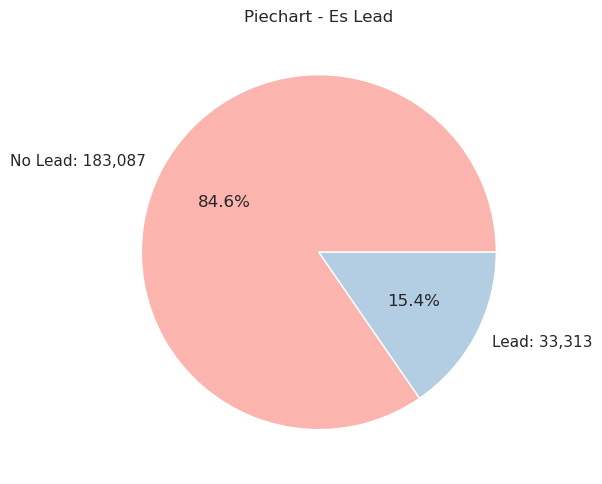

In [11]:
# ya que trabajaremos con clasificación, veamos cuántos casos hay de cada categoría:

fig, ax2 = plt.subplots(1, 1, figsize=(8, 5))
#sns.countplot(x=data.Is_Lead, ax=ax1)
#ax1.set_title('Countplot - Es Lead')
#for p in ax1.patches:
#    ax1.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
#                ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

create_piechart_with_values(data.Is_Lead, 'Piechart - Es Lead',ax2,['No Lead','Lead'])    

plt.tight_layout()
plt.show()


**Observaciones:**
    
Existe una desproporción muy grande entre las dos clases.

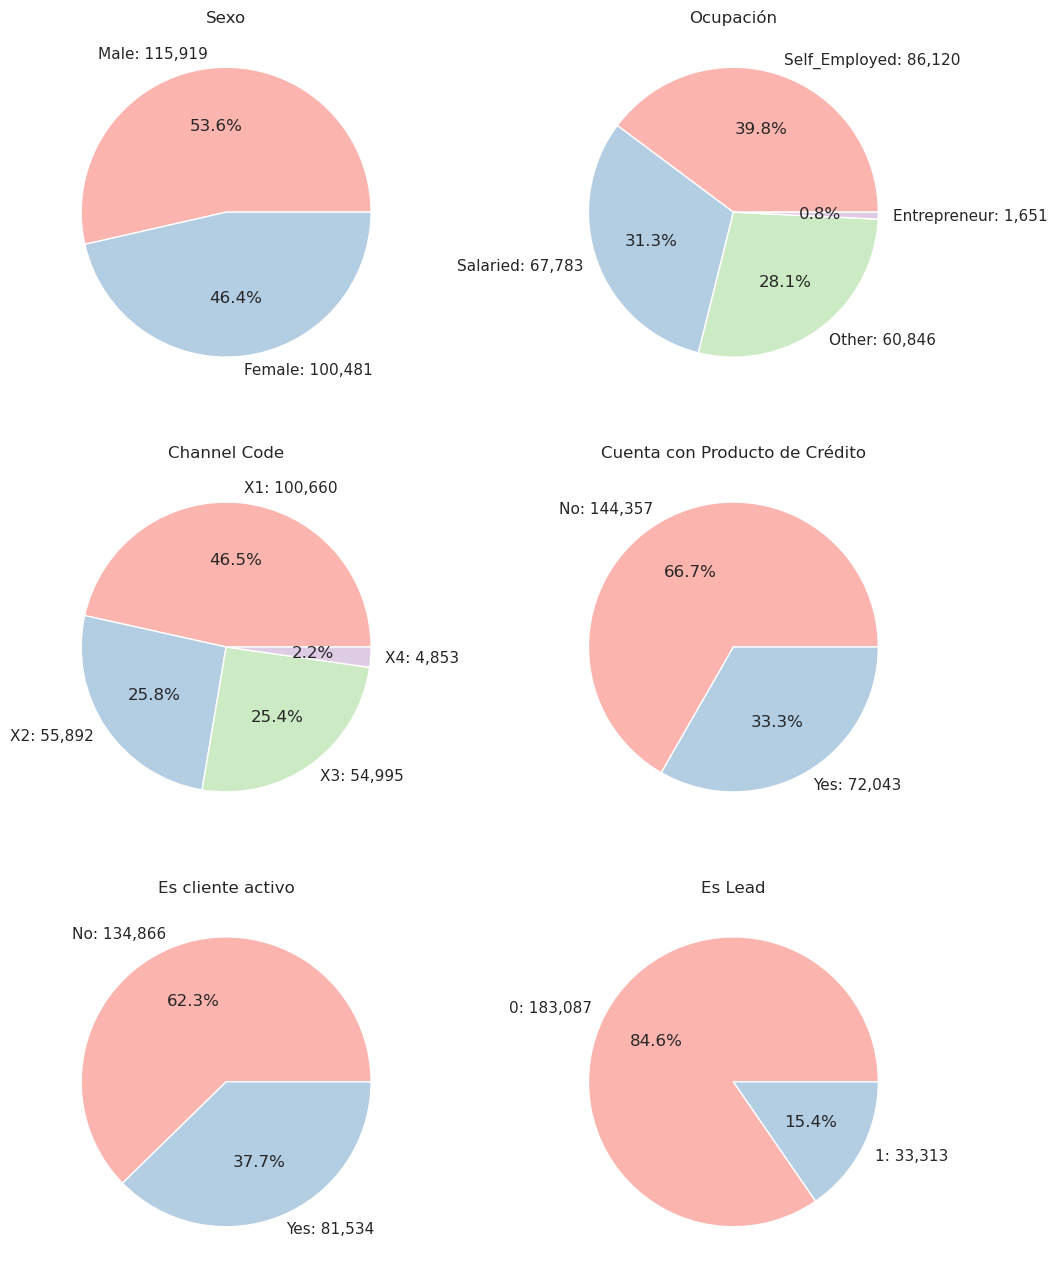

In [12]:
# Veamos las distribuciones de algunas variables:
fig, axes = plt.subplots(3, 2, figsize=(12, 16))

create_piechart_with_values(data.Gender, 'Sexo',axes[0][0])
create_piechart_with_values(data.Occupation, 'Ocupación',axes[0][1])
create_piechart_with_values(data.Channel_Code, 'Channel Code',axes[1][0])
create_piechart_with_values(data.Credit_Product, 'Cuenta con Producto de Crédito',axes[1][1])
create_piechart_with_values(data.Is_Active, 'Es cliente activo',axes[2][0])
create_piechart_with_values(data.Is_Lead, 'Es Lead',axes[2][1])

#plt.tight_layout()
plt.show()

Hay 35 valores distintos de Region_Code


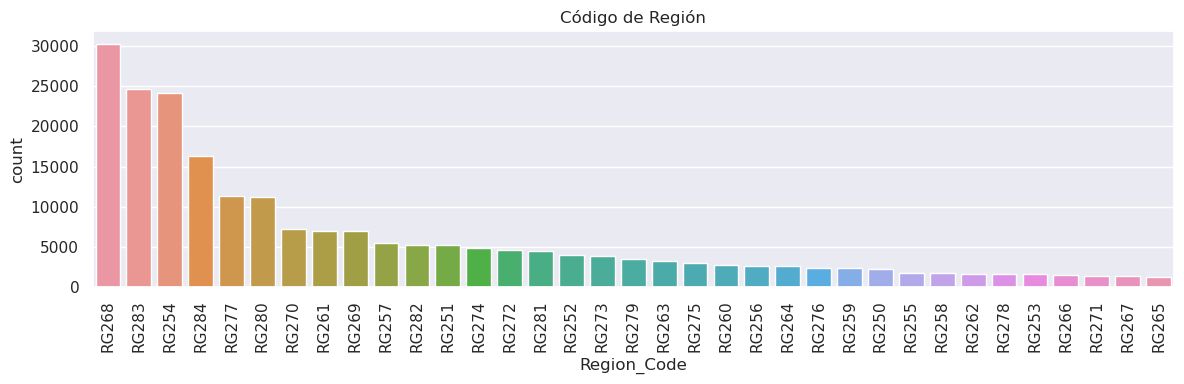

In [13]:
# Veamos las proporciones en algunas variables:
print('Hay',data.Region_Code.value_counts().shape[0],'valores distintos de Region_Code')

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
sns.countplot(data=data.sort_values(by='Region_Code'), x='Region_Code', ax=axes, order = data['Region_Code'].value_counts().index)
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set_title('Código de Región')
plt.tight_layout()

# Show the plot
plt.show()

**Observaciones:**

Más adelante podremos determinar si esta variable es relevante para la clasificación


#### Variables Numéricas

Veamos histogramas y boxplots para las variables numéricas que tienen nuestros datos

In [14]:
def createHist(data,titulo,nobins=None):
    fig, axes = plt.subplots(2, 1, figsize=(12, 4))
    #data = creditCardLeadDf['Avg_Account_Balance']
    #titulo = 'Balance Promedio'

    if nobins:
        sns.histplot(data,ax=axes[0],bins= (data.max()-data.min()) )
    else:
        sns.histplot(data,ax=axes[0] )
    axes[0].set_xlabel('Values')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(titulo+' - Histograma')

    sns.boxplot(x=data, ax=axes[1])
    mean_value = np.mean(data)
    axes[1].plot(mean_value, 0,  marker='o', color='red', label='Mean')
    axes[1].text(mean_value+mean_value/1.5, -.3, f"Mean: {mean_value:.2f}", color='teal', ha='left', va='center')
    #axes[1].set_xlabel('Values')
    #axes[1].set_ylabel('Count')
    axes[1].set_title(titulo+' - Boxplot')
    #axes[1].legend()


    plt.tight_layout()
    plt.show()


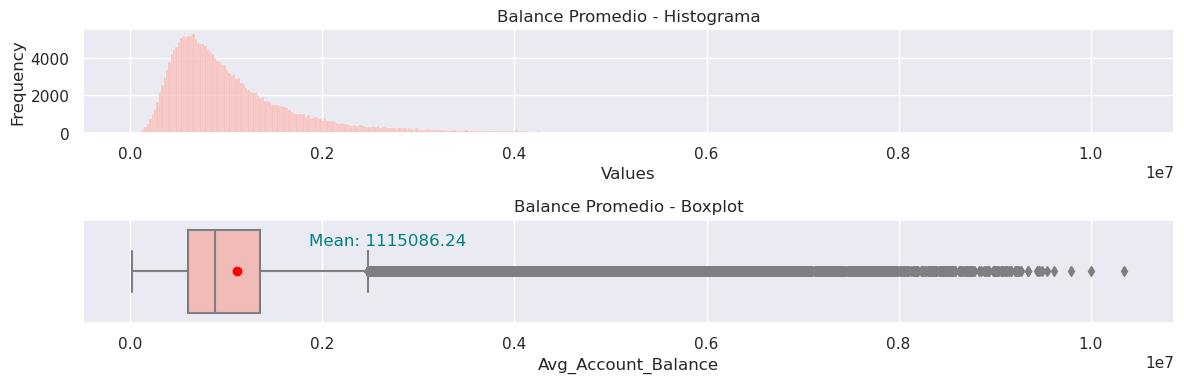

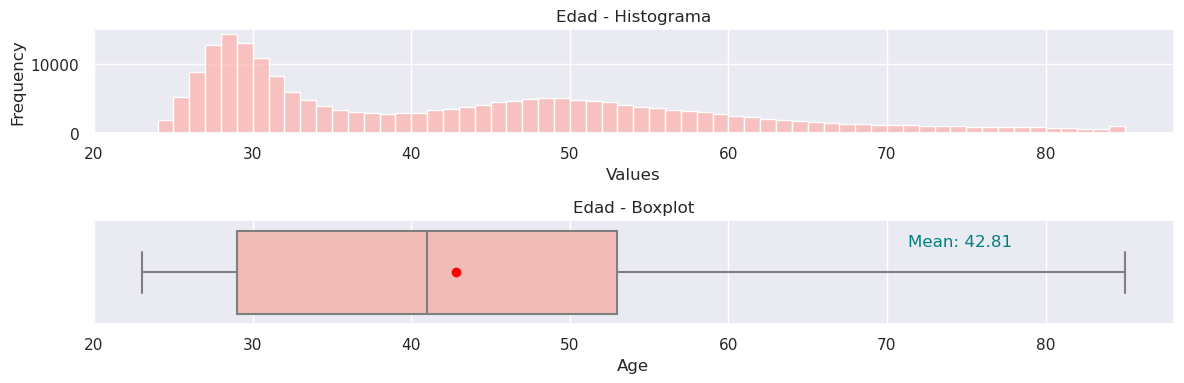

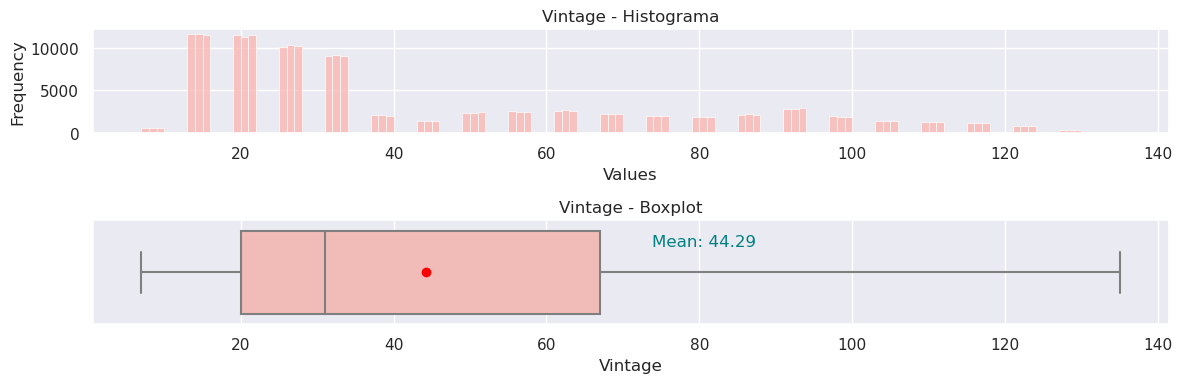

In [15]:
#sns.set_palette( palQualitative )
createHist(data['Avg_Account_Balance'],'Balance Promedio')
createHist(data['Age'],'Edad',nobins=True)
createHist(data['Vintage'],'Vintage',nobins=True)

In [16]:
# ya que la columna ID no aporta nada a la clasificación, la eliminaremos
data = data.drop('ID', axis=1)

In [17]:
data.head()

Gender  Age Region_Code     Occupation Channel_Code  Vintage  \
0  Female   73       RG268          Other           X3       43   
1  Female   30       RG277       Salaried           X1       32   
2  Female   56       RG268  Self_Employed           X3       26   
3    Male   34       RG270       Salaried           X1       19   
4  Female   30       RG282       Salaried           X1       33   

  Credit_Product  Avg_Account_Balance Is_Active  Is_Lead  
0             No              1045696        No        0  
1             No               581988        No        0  
2             No              1484315       Yes        0  
3             No               470454        No        0  
4             No               886787        No        0

#### Conversión de variables a one-hot encoding

Las siguientes columnas pueden ser codificadas como one-hot:

Gender (2 valores), Region_Code (35), Occupation (4), Channel_Code (4), Credit_Product (2), Is_Active (2)

In [18]:
# Codificamos en one-hot:
toOneHot = ['Gender', 'Occupation', 'Is_Active', 'Credit_Product','Channel_Code', 'Region_Code']
data = pd.get_dummies(data,columns=toOneHot)
print(data.shape)
display(data)

(216400, 53)


Age  Vintage  Avg_Account_Balance  Is_Lead  Gender_Female  \
0        73       43              1045696        0              1   
1        30       32               581988        0              1   
2        56       26              1484315        0              1   
3        34       19               470454        0              0   
4        30       33               886787        0              1   
...     ...      ...                  ...      ...            ...   
216395   38       13               354665        0              1   
216396   27       15               862952        0              0   
216397   26       13               670659        0              1   
216398   28       31               407504        0              1   
216399   29       21              1129276        0              0   

        Gender_Male  Occupation_Entrepreneur  Occupation_Other  \
0                 0                        0                 1   
1                 0                        0                 0   
2                 0                        0                 0   
3                 1                        0                 0   
4                 0                        0                 0   
...             ...                      ...               ...   
216395            0                        0                 0   
216396            1                        0                 0   
216397            0                        0                 0   
216398            0                        0                 0   
216399            1                        0                 0   

        Occupation_Salaried  Occupation_Self_Employed  ...  Region_Code_RG275  \
0                         0                         0  ...                  0   
1                         1                         0  ...                  0   
2                         0                         1  ...                  0   
3                         1                         0  ...                  0   
4                         1                         0  ...                  0   
...                     ...                       ...  ...                ...   
216395                    1                         0  ...                  0   
216396                    1                         0  ...                  0   
216397                    1                         0  ...                  0   
216398                    1                         0  ...                  0   
216399                    1                         0  ...                  0   

        Region_Code_RG276  Region_Code_RG277  Region_Code_RG278  \
0                       0                  0                  0   
1                       0                  1                  0   
2                       0                  0                  0   
3                       0                  0                  0   
4                       0                  0                  0   
...                   ...                ...                ...   
216395                  0                  0                  0   
216396                  0                  0                  0   
216397                  0                  0                  0   
216398                  0                  0                  0   
216399                  0                  0                  0   

        Region_Code_RG279  Region_Code_RG280  Region_Code_RG281  \
0                       0                  0                  0   
1                       0                  0                  0   
2                       0                  0                  0   
3                       0                  0                  0   
4                       0                  0                  0   
...                   ...                ...                ...   
216395                  0                  1                  0   
216396                  0                  0                  0   
21639

#### Eliminación de variables innecesarias

In [19]:
# Para las variables que originalmente eran binarias, podemos eliminar una de sus
# dos columnas provenientes de get_dummies (Gender, Is_Active, ):
print(data.shape)
data = data.drop(['Gender_Female','Is_Active_No','Credit_Product_No'], axis=1)
print(data.shape)

(216400, 53)
(216400, 50)


#### Correlaciones entre variables y variables-salida

In [20]:
# Tratemos de ver correlación entre las variables categóricas y la salida

#x_vars = [ x for x in list(data) if 'Occupation' in x] 
x_vars = list(data)

x_vars.remove('Avg_Account_Balance')
x_vars.remove('Age')
x_vars.remove('Vintage')
x_vars.remove('Is_Lead')

statData = []
for x_var in x_vars:
    contingency_table = pd.crosstab(data[x_var], data['Is_Lead'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    n = contingency_table.sum().sum()
    phi = np.sqrt(chi2 / (n * min(contingency_table.shape) - 1))
    v = phi / np.sqrt(min(contingency_table.shape) - 1)

    # P-value came higher than 0.05.
    # Hence H0 will be accepted.
    # Which means the variables are not correlated with each other.

    #pstring = "{:.30f}".format(p)
    #if p<0.005: # si p es menor a 0.005, rechazamos H0, entonces las variables están correlacionadas
    statData.append([x_var,chi2,p,dof,v])

names = ['variable','chi2','p','dof','Cramer V']
etests = pd.DataFrame(columns=names, data=statData)

print('Correlación Variables categórica - Is_Lead para p<0.005 usando chi2, ordenadas por el valor de índice Cramer V')
print("Número de variables correlacionadas con Is_Lead:",etests[etests.p<0.005].shape[0])
display(etests[(etests.p<0.005) & (etests['Cramer V']>0.1)].sort_values(by='Cramer V', ascending=False))

Correlación Variables categórica - Is_Lead para p<0.005 usando chi2, ordenadas por el valor de índice Cramer V
Número de variables correlacionadas con Is_Lead: 31


variable          chi2    p  dof  Cramer V
6  Credit_Product_Yes  21494.008811  0.0    1  0.222852
7     Channel_Code_X1  10575.366679  0.0    1  0.156316
9     Channel_Code_X3   4905.809597  0.0    1  0.106466

**Observaciones:**
    
Aproximandamente la mitad las variables categóricas tienen correlación con Is_Lead. Sin embargo, esta correlación es demasiado pequeña. Sólo tres variables mostraron un valor de Cramer V mayor a 0.1 que indica una correlación pequeña:

- Credit_Product_Yes
- Channel_Code_X1
- Channel_Code_X3

In [21]:
# veamos correlación entre variables categoricas con ellas mismas
x_vars = list(data)

#tmp = [ x for x in x_vars if 'Channel' not in x] 
#x_vars = tmp

tmp = [ x for x in x_vars if 'Region' not in x] 
x_vars = tmp

x_vars.remove('Avg_Account_Balance')
x_vars.remove('Age')
x_vars.remove('Vintage')
x_vars.remove('Is_Lead')

statData = []
statDataVarsList = []
for x_var1 in x_vars:
    for x_var2 in x_vars:
        if x_var1 == x_var2 or ('Occupation' in x_var1 and 'Occupation' in x_var2) or ('Channel' in x_var1 and 'Channel' in x_var2):
            continue
        contingency_table = pd.crosstab(data[x_var1], data[x_var2])
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        n = contingency_table.sum().sum()
        phi = np.sqrt(chi2 / (n * min(contingency_table.shape) - 1))
        v = phi / np.sqrt(min(contingency_table.shape) - 1)

        # P-value came higher than 0.05.
        # Hence H0 will be accepted.
        # Which means the variables are not correlated with each other.

        #pstring = "{:.30f}".format(p)
        #if p<0.005: # si p es menor a 0.005, rechazamos H0, entonces las variables están correlacionadas

        if x_var2+' - '+x_var1 not in statDataVarsList:
            statDataVarsList.append(x_var1+' - '+x_var2)
            statData.append([x_var1+' - '+x_var2,chi2,p,dof,v])

names = ['variables','chi2','p','dof','Cramer V']
etests = pd.DataFrame(columns=names, data=statData)

print('Correlación entre las variables categorícas (sin mostrar correlaciones de Region con Region, Occupation con Occupation)')
display(etests[(etests.p<0.005) & (etests['Cramer V']>=0.1) ].sort_values(by='Cramer V', ascending=False))


Correlación entre las variables categorícas (sin mostrar correlaciones de Region con Region, Occupation con Occupation)


variables          chi2    p  dof  \
24       Occupation_Salaried - Channel_Code_X1  78629.799355  0.0    1   
30  Occupation_Self_Employed - Channel_Code_X1  45864.623629  0.0    1   
25       Occupation_Salaried - Channel_Code_X2  25888.824050  0.0    1   
26       Occupation_Salaried - Channel_Code_X3  22097.164017  0.0    1   
31  Occupation_Self_Employed - Channel_Code_X2  21952.784071  0.0    1   
35             Is_Active_Yes - Channel_Code_X1  20521.021831  0.0    1   
39        Credit_Product_Yes - Channel_Code_X1  14723.141506  0.0    1   
22         Occupation_Salaried - Is_Active_Yes  10388.736527  0.0    1   
6                Gender_Male - Channel_Code_X1   7527.735484  0.0    1   
32  Occupation_Self_Employed - Channel_Code_X3   7137.606533  0.0    1   
36             Is_Active_Yes - Channel_Code_X2   7127.799172  0.0    1   
28    Occupation_Self_Employed - Is_Active_Yes   6834.370384  0.0    1   
41        Credit_Product_Yes - Channel_Code_X3   6015.792288  0.0    1   
37             Is_Active_Yes - Channel_Code_X3   5508.137930  0.0    1   
23    Occupation_Salaried - Credit_Product_Yes   5022.104052  0.0    1   

    Cramer V  
24  0.426236  
30  0.325534  
25  0.244576  
26  0.225957  
31  0.225217  
35  0.217749  
39  0.184441  
22  0.154931  
6   0.131883  
32  0.128420  
36  0.128332  
28  0.125663  
41  0.117897  
37  0.112813  
23  0.107721

In [22]:
x_vars=['Avg_Account_Balance','Age','Vintage']
statData = []
for var in x_vars:
    correlation_coefficient, p_value = pointbiserialr(data['Is_Lead'], data[var])
    statData.append([var,correlation_coefficient,p_value])

names = ['Variable','Point Biserial Correlation Coefficient','P value']
etests = pd.DataFrame(columns=names, data=statData)

display( etests[etests['P value']<0.005].sort_values(by='Point Biserial Correlation Coefficient',ascending=False)  )

# Close to 0: Indicates no or negligible correlation.
# 0.1 to 0.3 (or -0.1 to -0.3): Indicates a small or weak correlation.
# 0.3 to 0.5 (or -0.3 to -0.5): Indicates a moderate correlation.
# Above 0.5 (or below -0.5): Indicates a strong correlation.


Variable  Point Biserial Correlation Coefficient       P value
2              Vintage                                0.223750  0.000000e+00
1                  Age                                0.175344  0.000000e+00
0  Avg_Account_Balance                                0.042533  3.315459e-87

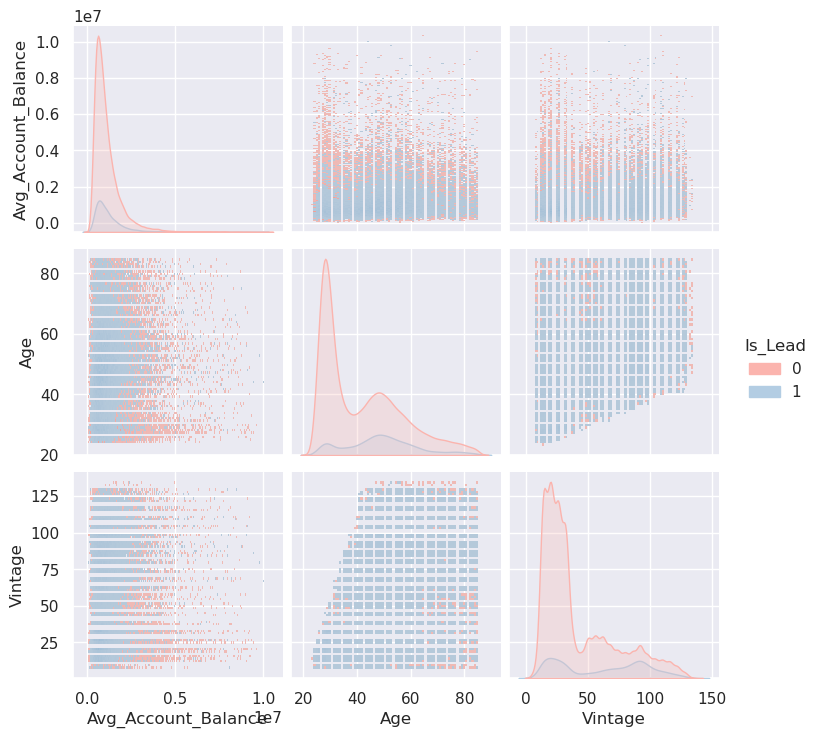

In [23]:
# Y ahora veamos la correclación entre esas tres variables
sns.pairplot(data, vars=x_vars, hue='Is_Lead', kind = "hist", diag_kind = 'kde')

# Observaciones:
# No encotramos mucha correlación entre éstas

In [24]:
# También vemos la correlación entre estas variables usando Spearman
display(data[x_vars].corr(method="spearman"))

# Observaciones:
# Se observa una correlación significativa entre Age y Vintage, lo cual es de esperarse porque
# sólo la gente de mayor edad puede tener más historial crediticio
# (Yo esperaba encontrar más correlación entre edad y balance)

Avg_Account_Balance       Age   Vintage
Avg_Account_Balance             1.000000  0.168859  0.184243
Age                             0.168859  1.000000  0.655250
Vintage                         0.184243  0.655250  1.000000

**Observaciones:**
    
Age y Vintage tienen correlación moderada (explicable ya que sólo clientes con mayor edad pueden tener un historial crediticio más alto)

## (fin de EDA)

Ya que no tenemos las etiquetas del test dataset proporcionado, reservaremos una parte de nuestro trainset para usarlo como test dataset en lugar de TESTDATA.

In [25]:
dataBeforeReserve=data.copy()

fraction = 1-RESERVE_FOR_TEST
data = dataBeforeReserve.sample(frac=fraction,random_state=23)
data.reset_index(inplace=True,drop=True)

RESERVED_TEST = dataBeforeReserve.drop(data.index)
RESERVED_TEST.reset_index(inplace=True,drop=True)

X_TEST_RESERVED = RESERVED_TEST.drop('Is_Lead',axis=1)
y_TEST_RESERVED = RESERVED_TEST['Is_Lead']

In [26]:
print("Full dataset before RESERVE:", dataBeforeReserve.shape)
print("Train Dataset:",data.shape)
print("RESERVED TEST Dataset:",RESERVED_TEST.shape)
print(data.shape[0]+RESERVED_TEST.shape[0])

Full dataset before RESERVE: (216400, 50)
Train Dataset: (151480, 50)
RESERVED TEST Dataset: (64920, 50)
216400


#### Preparación de datos Test para los modelos

In [27]:
trainDataFull = data.copy()

In [28]:
# Ejecutar desde aquí para diferentes pruebas con fracciones de los datos originales
if DATA_FRACTION<1:
    data = trainDataFull.sample(frac=DATA_FRACTION,random_state=23)
    data.reset_index(inplace=True,drop=True)

print("Fracción de datos utlizados para entrenamiento:", DATA_FRACTION*100,'%')
print('Full Data size:',trainDataFull.shape)
print('Train Data size:',data.shape)

Fracción de datos utlizados para entrenamiento: 100 %
Full Data size: (151480, 50)
Train Data size: (151480, 50)


#### Primer splitting para entrenar

In [29]:
X = data.drop('Is_Lead',axis=1)
y = data['Is_Lead']

### Exploración de selección de features con SelectKBest

In [30]:
# Selección de Features con Threshold fue descartada debido al alto número de variables categpóicas
from sklearn.feature_selection import chi2 # selección de features categoricas
best=10
selector = SelectKBest(k=best,score_func=chi2)

#scaler = MinMaxScaler()
#XScaled = scaler.fit_transform(X)
#XScaled = pd.DataFrame(data=XScaled, columns=list(X))

selector.fit(X,y)
print(f'Las {best} mejores features según SelectKBest son:')
for col in selector.get_feature_names_out():
    print(f'   {col}')


Las 10 mejores features según SelectKBest son:
   Age
   Vintage
   Avg_Account_Balance
   Occupation_Entrepreneur
   Occupation_Salaried
   Is_Active_Yes
   Credit_Product_Yes
   Channel_Code_X1
   Channel_Code_X2
   Channel_Code_X3


**Observaciones:**

Para KBest usamos la distrución chi2 que es recomendada para cuando se cuenta con variables categóricas.

Las 3 variables numéricas son las más importantes de acuerdo al selector. También confirmamos que de las variables categóricas, Occupation_Entrepreneur juega el papel más importante importante.

### Clasificación con árboles de decisión

#### Arboles de decisión con datos originales (1/3)

In [31]:
# dataframe para guardar performace metrics cuando hagamos la prueba con X_TEST_RESERVED
treesPerformances = pd.DataFrame(columns=['Training Data', 'Acc','Recall','Precision', 'F1','Roc-Auc'])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

In [33]:
# guardemos X_test y_test originales para usarlos en los dos árboles finales:
#X_test_original = X_test.copy()
#y_test_original = y_test.copy()

In [34]:
def plotRocAucCurve(y, y_pred_proba, ax, title=None):
    fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
    #ax.title("Curva ROC (train)") 
    ax.plot(fpr,tpr,color='red')
    ax.plot([0,1],[0,1],linestyle='--',color='gray')
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    if title: ax.set_title(title)
        
def plotCM(y_test,y_pred,ax,title=None):
    target_labels = ['No Lead','Lead']
    cm = confusion_matrix(y_test,y_pred)
    ax = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
    xticklabels=target_labels,
    yticklabels=target_labels)
    ax.set(xlabel='Predicted',ylabel='Real')
    for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
    if title: ax.set_title(title)

Resultados usando datos originales (sin resampling)
X_train: 106,036, X_test: 45,444, y_train: 106,036, y_test: 45,444
Accuracy: 0.793
Recall: 0.359
Precision: 0.334
F1: 0.346
ROC-AUC: 0.6153140999611885


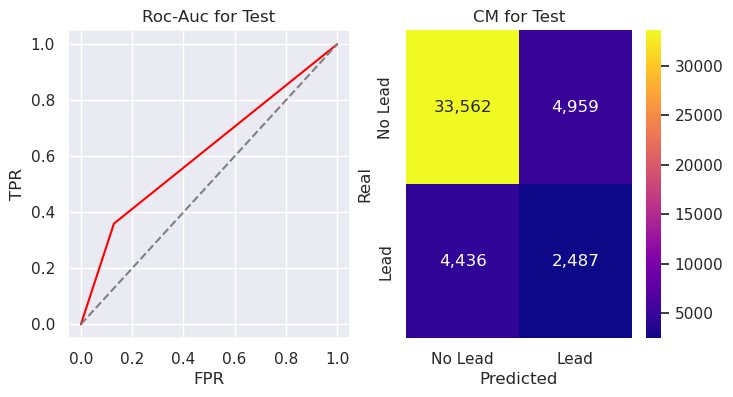

importancia
feature                         
Avg_Account_Balance        0.306
Vintage                    0.155
Age                        0.149
Credit_Product_Yes         0.097
Occupation_Salaried        0.029
Gender_Male                0.028
Is_Active_Yes              0.023
Region_Code_RG268          0.015
Region_Code_RG283          0.014
Channel_Code_X2            0.012

In [35]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]
pmAccuracy=round(accuracy_score(y_test,y_pred),3)
pmRecall=round(recall_score(y_test,y_pred),3)
pmPrecision=round(precision_score(y_test,y_pred),3)
pmF1=round(f1_score(y_test, y_pred),3)
pmRocAuc = roc_auc_score(y_test, y_pred_proba)

print(f"Resultados usando datos originales (sin resampling)")

print('X_train: {:,d}, X_test: {:,d}, y_train: {:,d}, y_test: {:,d}'.format(X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0]))

print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")
print(f"F1: {pmF1}")
print(f"ROC-AUC: {pmRocAuc}")

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plotCM(y_test,y_pred,ax[1],title='CM for Test')
plotRocAucCurve(y_test, y_pred_proba, ax[0], title='Roc-Auc for Test')
plt.show()

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

Resultados usando datos originales (sin resampling) - Usando TEST_RESERVED
Accuracy: 0.895
Recall: 0.675
Precision: 0.647
F1: 0.661
ROC-AUC: 0.8044030154083354


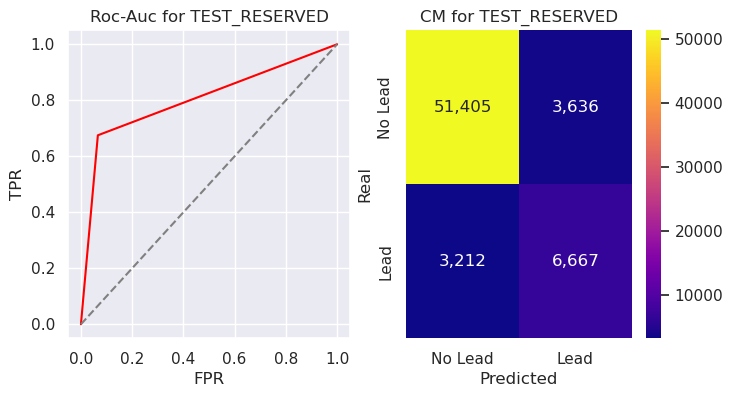

importancia
feature                         
Avg_Account_Balance        0.306
Vintage                    0.155
Age                        0.149
Credit_Product_Yes         0.097
Occupation_Salaried        0.029
Gender_Male                0.028
Is_Active_Yes              0.023
Region_Code_RG268          0.015
Region_Code_RG283          0.014
Channel_Code_X2            0.012

In [36]:
# prueba con X_TEST_RESERVED
y_pred = clf.predict(X_TEST_RESERVED)
y_pred_proba = clf.predict_proba(X_TEST_RESERVED)[:, 1]
pmAccuracy=round(accuracy_score(y_TEST_RESERVED,y_pred),3)
pmRecall=round(recall_score(y_TEST_RESERVED,y_pred),3)
pmPrecision=round(precision_score(y_TEST_RESERVED,y_pred),3)
pmF1=round(f1_score(y_TEST_RESERVED, y_pred),3)
pmRocAuc = roc_auc_score(y_TEST_RESERVED, y_pred_proba)

print(f"Resultados usando datos originales (sin resampling) - Usando TEST_RESERVED")

treesPerformances.loc[len(treesPerformances.index)] = ['Original Data', pmAccuracy, pmRecall, pmPrecision, pmF1, pmRocAuc ] 
print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")
print(f"F1: {pmF1}")
print(f"ROC-AUC: {pmRocAuc}")

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plotCM(y_TEST_RESERVED,y_pred,ax[1],title='CM for TEST_RESERVED')
plotRocAucCurve(y_TEST_RESERVED, y_pred_proba, ax[0], title='Roc-Auc for TEST_RESERVED')
plt.show()

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

**Observaciones:**
    
Al parecer el hecho de que los ejemplos están desbalanceados affecta el desempeño del modelo. A continuación balancearemos los ejemplos por medio de sub/over sampling.


#### Árboles de decisión con datos submuestreados  (1/2)

In [37]:
#Submuestreo

# lista los índices de Is_Lead
lead_idxs = data[data["Is_Lead"]==1].index.to_list()

# lista de índices que no son lead
nolead_idxs = data[data["Is_Lead"]==0].index.to_list()

# seleccionamos aleatoriamente el doble de índices de no leads
random_nolead_idxs = np.random.choice(nolead_idxs, int(len(lead_idxs)*1.5), replace= False)
print('random picks len:',len(random_nolead_idxs))

# concatenamos los índices fraudulentos y normales y creamos el dataframe sub-sampleado
undersampled_indices = np.concatenate([lead_idxs, random_nolead_idxs])
undersampled_data = data.iloc[undersampled_indices,:]



random picks len: 34695


In [38]:
print(f"Sin undersampling: Lead: {len(lead_idxs)}, No Lead: {len(random_nolead_idxs)}")
print(f'Tamaño de data sin resampling: {data.shape}')
print(f'Tamaño de data luego de resampling: {undersampled_data.shape}')

Sin undersampling: Lead: 23130, No Lead: 34695
Tamaño de data sin resampling: (151480, 50)
Tamaño de data luego de resampling: (57825, 50)


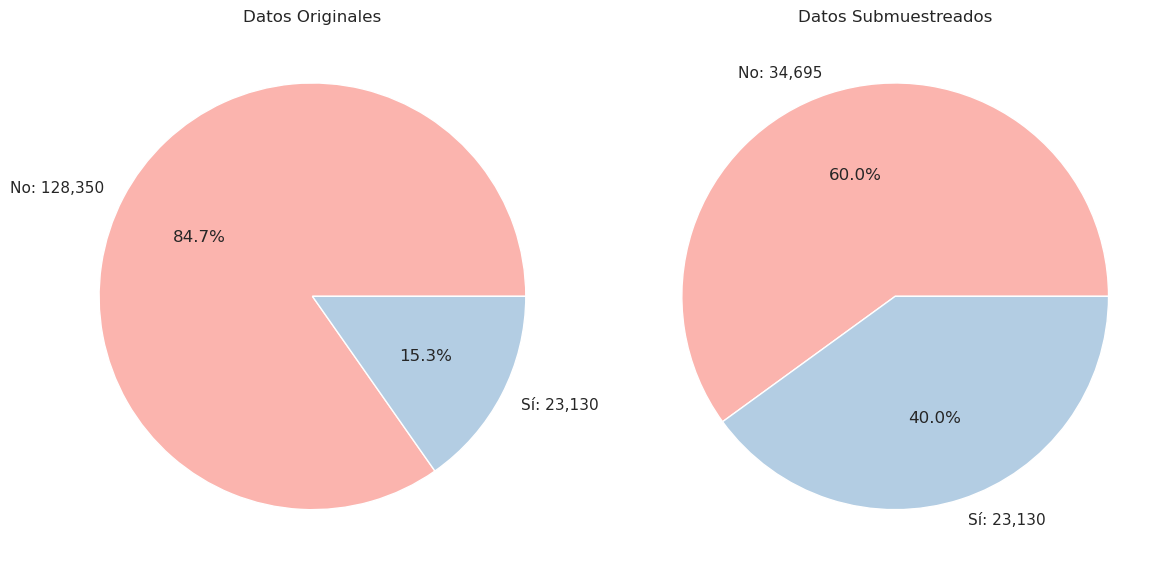

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

create_piechart_with_values(data.Is_Lead, 'Datos Originales',ax1,['No','Sí'])    
create_piechart_with_values(undersampled_data.Is_Lead, 'Datos Submuestreados',ax2,['No','Sí'])    

plt.tight_layout()
plt.show()

In [40]:
X = undersampled_data.drop('Is_Lead',axis=1)
y = undersampled_data['Is_Lead']

print(Counter(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

Counter({0: 34695, 1: 23130})


Resultados usando datos submuestreados
X_train: 40,477, X_test: 17,348, y_train: 40,477, y_test: 17,348
Accuracy: 0.659
Recall: 0.577
Precision: 0.578
F1: 0.577
ROC-AUC: 0.6456347665390952


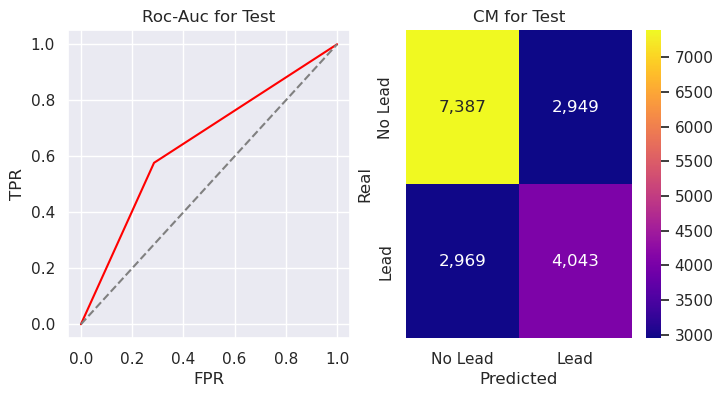

importancia
feature                         
Avg_Account_Balance        0.265
Age                        0.158
Credit_Product_Yes         0.158
Vintage                    0.144
Gender_Male                0.026
Is_Active_Yes              0.022
Occupation_Salaried        0.018
Region_Code_RG268          0.015
Region_Code_RG283          0.014
Region_Code_RG254          0.013

In [41]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]
pmAccuracy=round(accuracy_score(y_test,y_pred),3)
pmRecall=round(recall_score(y_test,y_pred),3)
pmPrecision=round(precision_score(y_test,y_pred),3)
pmF1=round(f1_score(y_test, y_pred),3)
pmRocAuc = roc_auc_score(y_test, y_pred_proba)

print(f"Resultados usando datos submuestreados")

print('X_train: {:,d}, X_test: {:,d}, y_train: {:,d}, y_test: {:,d}'.format(X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0]))

print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")
print(f"F1: {pmF1}")
print(f"ROC-AUC: {pmRocAuc}")

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plotCM(y_test,y_pred,ax[1],title='CM for Test')
plotRocAucCurve(y_test, y_pred_proba, ax[0], title='Roc-Auc for Test')
plt.show()

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

Resultados usando datos submuestreados - Usando TEST_RESERVED
Accuracy: 0.752
Recall: 0.781
Precision: 0.356
F1: 0.489
ROC-AUC: 0.7636744638467972


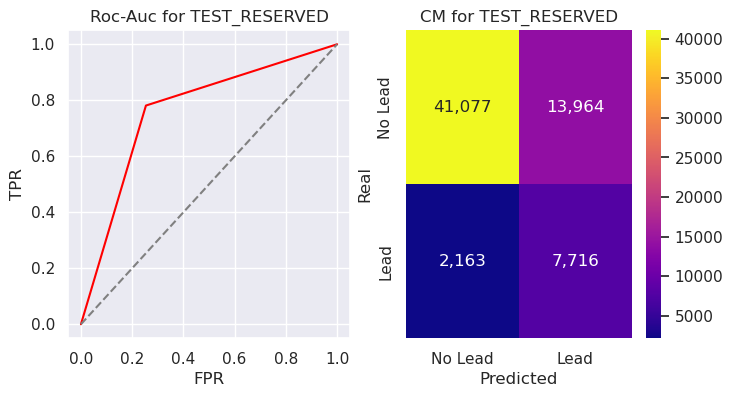

importancia
feature                         
Avg_Account_Balance        0.265
Age                        0.158
Credit_Product_Yes         0.158
Vintage                    0.144
Gender_Male                0.026
Is_Active_Yes              0.022
Occupation_Salaried        0.018
Region_Code_RG268          0.015
Region_Code_RG283          0.014
Region_Code_RG254          0.013

In [42]:
# prueba con X_TEST_RESERVED
y_pred = clf.predict(X_TEST_RESERVED)
y_pred_proba = clf.predict_proba(X_TEST_RESERVED)[:, 1]
pmAccuracy=round(accuracy_score(y_TEST_RESERVED,y_pred),3)
pmRecall=round(recall_score(y_TEST_RESERVED,y_pred),3)
pmPrecision=round(precision_score(y_TEST_RESERVED,y_pred),3)
pmF1=round(f1_score(y_TEST_RESERVED, y_pred),3)
pmRocAuc = roc_auc_score(y_TEST_RESERVED, y_pred_proba)

print(f"Resultados usando datos submuestreados - Usando TEST_RESERVED")

treesPerformances.loc[len(treesPerformances.index)] = ['Subsampled Data', pmAccuracy, pmRecall, pmPrecision, pmF1, pmRocAuc ] 
print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")
print(f"F1: {pmF1}")
print(f"ROC-AUC: {pmRocAuc}")

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plotCM(y_TEST_RESERVED,y_pred,ax[1],title='CM for TEST_RESERVED')
plotRocAucCurve(y_TEST_RESERVED, y_pred_proba, ax[0], title='Roc-Auc for TEST_RESERVED')
plt.show()

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

#### Árboles de decisión con oversampling  (3/3)

In [43]:
print('Datos de entrada a SMOTE:',data.shape)

oversample = SMOTE()

X = data.drop('Is_Lead',axis=1)
y = data['Is_Lead']
X_oversampled, y_oversampled = oversample.fit_resample(X, y)
print(Counter(y_oversampled))

print("Datos SMOTE originales X, y:", X_oversampled.shape,y_oversampled.shape)

# lista los índices sampleados
smoteSampleIdxs = X_oversampled.index.to_list()
print('smoteSampleIdx lenght:',len(smoteSampleIdxs))
np.random.seed(23)
randomSmoteSampleIdxs = np.random.choice(smoteSampleIdxs, int(len(smoteSampleIdxs)*SMOTE_FRACTION), replace= False)
X_oversampled = X_oversampled.iloc[randomSmoteSampleIdxs,:]
y_oversampled = y_oversampled.iloc[randomSmoteSampleIdxs]

print("Fracción de datos SMOTE utlizados:", SMOTE_FRACTION*100,'%')
print(f"Matriz de features: {X_oversampled.shape}")
print(f"Matriz de etiquetas: {y_oversampled.shape}")

print(Counter(y_oversampled))

Datos de entrada a SMOTE: (151480, 50)
Counter({0: 128350, 1: 128350})
Datos SMOTE originales X, y: (256700, 49) (256700,)
smoteSampleIdx lenght: 256700
Fracción de datos SMOTE utlizados: 75.0 %
Matriz de features: (192525, 49)
Matriz de etiquetas: (192525,)
Counter({0: 96403, 1: 96122})


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.3) # 70% training and 30% test
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

Resultados usando datos sobremuestreados
X_train: 134,767, X_test: 57,758, y_train: 134,767, y_test: 57,758
Accuracy: 0.859
Recall: 0.867
Precision: 0.853
F1: 0.86
ROC-AUC: 0.8594744865350649


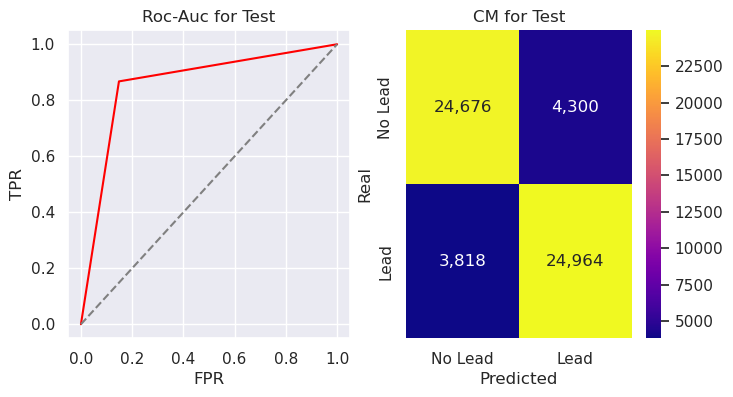

importancia
feature                              
Channel_Code_X1                 0.230
Avg_Account_Balance             0.127
Occupation_Other                0.123
Occupation_Self_Employed        0.098
Vintage                         0.081
Age                             0.069
Channel_Code_X3                 0.052
Channel_Code_X2                 0.035
Channel_Code_X4                 0.030
Credit_Product_Yes              0.022

In [45]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]
pmAccuracy=round(accuracy_score(y_test,y_pred),3)
pmRecall=round(recall_score(y_test,y_pred),3)
pmPrecision=round(precision_score(y_test,y_pred),3)
pmF1=round(f1_score(y_test, y_pred),3)
pmRocAuc = roc_auc_score(y_test, y_pred_proba)

print(f"Resultados usando datos sobremuestreados")

print('X_train: {:,d}, X_test: {:,d}, y_train: {:,d}, y_test: {:,d}'.format(X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0]))

print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")
print(f"F1: {pmF1}")
print(f"ROC-AUC: {pmRocAuc}")

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plotCM(y_test,y_pred,ax[1],title='CM for Test')
plotRocAucCurve(y_test, y_pred_proba, ax[0], title='Roc-Auc for Test')
plt.show()

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

Resultados usando datos sobremuestreados - Usando TEST_RESERVED
Accuracy: 0.862
Recall: 0.616
Precision: 0.541
F1: 0.576
ROC-AUC: 0.7611387040286722


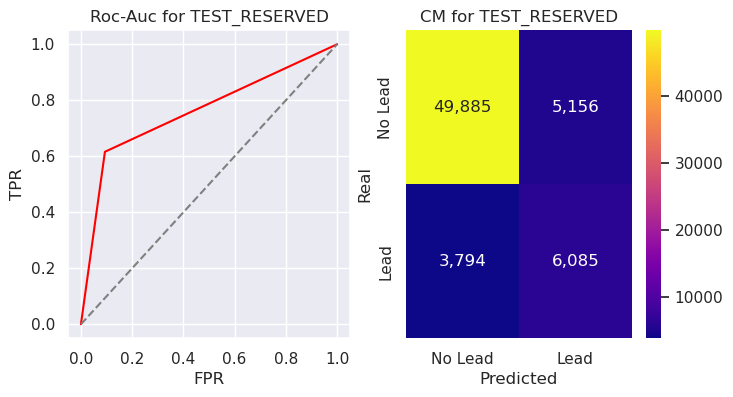

importancia
feature                              
Channel_Code_X1                 0.230
Avg_Account_Balance             0.127
Occupation_Other                0.123
Occupation_Self_Employed        0.098
Vintage                         0.081
Age                             0.069
Channel_Code_X3                 0.052
Channel_Code_X2                 0.035
Channel_Code_X4                 0.030
Credit_Product_Yes              0.022

In [46]:
# prueba con X_TEST_RESERVED
y_pred = clf.predict(X_TEST_RESERVED)
y_pred_proba = clf.predict_proba(X_TEST_RESERVED)[:, 1]
pmAccuracy=round(accuracy_score(y_TEST_RESERVED,y_pred),3)
pmRecall=round(recall_score(y_TEST_RESERVED,y_pred),3)
pmPrecision=round(precision_score(y_TEST_RESERVED,y_pred),3)
pmF1=round(f1_score(y_TEST_RESERVED, y_pred),3)
pmRocAuc = roc_auc_score(y_TEST_RESERVED, y_pred_proba)

print(f"Resultados usando datos sobremuestreados - Usando TEST_RESERVED")

treesPerformances.loc[len(treesPerformances.index)] = ['Oversampled Data', pmAccuracy, pmRecall, pmPrecision, pmF1, pmRocAuc ] 
print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")
print(f"F1: {pmF1}")
print(f"ROC-AUC: {pmRocAuc}")

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plotCM(y_TEST_RESERVED,y_pred,ax[1],title='CM for TEST_RESERVED')
plotRocAucCurve(y_TEST_RESERVED, y_pred_proba, ax[0], title='Roc-Auc for TEST_RESERVED')
plt.show()

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

In [47]:
print("Representación en texto del árbol entrenado con datos sobremuestreados")
text_representation = tree.export_text(decision_tree=clf)
print(X_train.columns[9])
print(text_representation)

Representación en texto del árbol entrenado con datos sobremuestreados
Credit_Product_Yes
|--- feature_10 <= 0.50
|   |--- feature_7 <= 0.50
|   |   |--- feature_5 <= 0.50
|   |   |   |--- feature_6 <= 0.50
|   |   |   |   |--- feature_4 <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_4 >  0.50
|   |   |   |   |   |--- feature_1 <= 62.50
|   |   |   |   |   |   |--- feature_8 <= 0.50
|   |   |   |   |   |   |   |--- feature_2 <= 409088.00
|   |   |   |   |   |   |   |   |--- feature_2 <= 336709.00
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_2 >  336709.00
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- feature_2 >  409088.00
|   |   |   |   |   |   |   |   |--- feature_1 <= 43.50
|   |   |   |   |   |   |   |   |   |--- feature_2 <= 1223278.00
|   |   |   |   |   |   |   |   |   |   |--- feature_2 <= 1072080.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of

#### Comparación de métricas de rendimiento para 3 árboles de decisión entrenados con diferentes sets de datos (sin resample, oversampled, subsampled), probados con los datos reservados para test (X_TEST_RESERVED)

In [48]:
display(treesPerformances.sort_values(by='Acc', ascending=False))

Training Data    Acc  Recall  Precision     F1   Roc-Auc
0     Original Data  0.895   0.675      0.647  0.661  0.804403
2  Oversampled Data  0.862   0.616      0.541  0.576  0.761139
1   Subsampled Data  0.752   0.781      0.356  0.489  0.763674

### Exploración de componentes pricipales

X_train: 106,036, X_test: 45,444, y_train: 106,036, y_test: 45,444
Train data antes de reducción de dimensionalidad: (151480, 49)
Train data luego de reducción de dimensionalidad: (151480, 25)
El 70.0% de la varianza se obtiene con 7 componentes principales



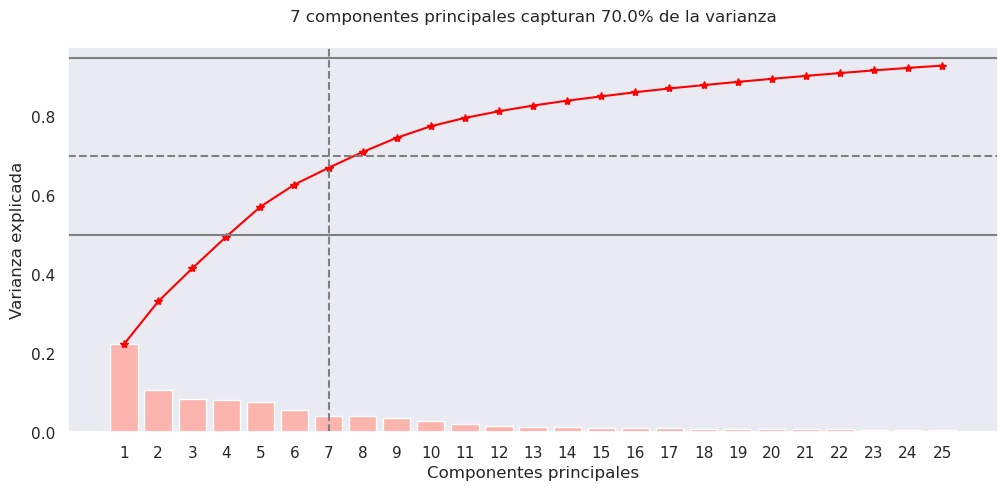

In [49]:
X = data.drop('Is_Lead',axis=1)
y = data['Is_Lead']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test

print('X_train: {:,d}, X_test: {:,d}, y_train: {:,d}, y_test: {:,d}'.format(X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0]))

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=25)
X_red = pca.fit_transform(X_scaled)
#X_challenge_red = pca.transform(X_challenge_scaled)

print('Train data antes de reducción de dimensionalidad:',X.shape)
print('Train data luego de reducción de dimensionalidad:',X_red.shape)
#print('Test data luego de reducción de dimensionalidad:',X_challenge_red.shape)

xs = list(range(1, pca.explained_variance_ratio_.shape[0]+1))
capturedVarThreshold = .70

plt.figure(figsize=(12,5))
plt.bar(xs, pca.explained_variance_ratio_)
plt.xticks(xs)
plt.plot(xs, np.cumsum(pca.explained_variance_ratio_), '-*',color='red')
plt.grid()
plt.xlabel("Componentes principales")
plt.ylabel("Varianza explicada")

captured = np.cumsum(pca.explained_variance_ratio_)
#print(f"Varianza explicada por cada una de las componentes principales:\n{pca.explained_variance_ratio_}\n")
#print(f"Varianza acumulada explicada por cada una de las componentes principales:\n{captured)}\n")

plt.axhline(.5,color='gray',linestyle='-')
plt.axhline(.95,color='gray',linestyle='-')

maxPC = np.where(captured >= capturedVarThreshold)[0][0]
plt.axhline(capturedVarThreshold,color='gray',linestyle='--')
plt.axvline(maxPC,color='gray',linestyle='--')
#plt.xticks(rotation=80)

plt.title(f"{maxPC} componentes principales capturan {capturedVarThreshold*100}% de la varianza\n")

print(f"El {capturedVarThreshold*100}% de la varianza se obtiene con {maxPC} componentes principales\n")

### Selección de datos a utilizar en entrenamiento (original, subsampled, oversampled)

In [50]:
if DATA_TO_USE == 'over':
    X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.3, random_state=101) # 70% training and 30% test
    X = X_oversampled
    y = y_oversampled
elif DATA_TO_USE == 'sub':
    X = undersampled_data.drop('Is_Lead',axis=1)
    y = undersampled_data['Is_Lead']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test
elif DATA_TO_USE == 'orig':
    X = data.drop('Is_Lead',axis=1)
    y = data['Is_Lead']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test

print(f"Usando data: {DATA_TO_USE}")    
print('X_train: {:,d}, X_test: {:,d}, y_train: {:,d}, y_test: {:,d}'.format(X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0]))

Usando data: over
X_train: 134,767, X_test: 57,758, y_train: 134,767, y_test: 57,758


### Preparación de pipeline y grid search para prueba de múltiples clasificadores con múltiples hiperparámetros

Usaremos los datos ~~submuestreados~~ sobremuestreados.

In [51]:
# dataframe para guardar performace metrics
classifiersPerformances = pd.DataFrame(columns=['Classifier','Data',
                                                'Acc','Recall','Precision','F1','Roc-Auc',
                                               ])

In [52]:
SCALER = True
POLY = False
DIMRED = True # si no hacemos dimRed el fitting toma demasiado tiempo
PCA_COMPONENTS = maxPC 

# CLASSIFIER /////////////////////(editar para cambiar el clasificador)/////////////////////
#classifier = RandomForestClassifier(n_jobs=-1)
classifier = SVC(probability=True)
#classifier =  RidgeClassifier()

# SCALER OBJECT
scaler = MinMaxScaler() if SCALER else None
#scaler = StandardScaler()

# POLYNOMIAL FEATURES OBJECT
poly = PolynomialFeatures(include_bias=True) if POLY else None

# DIMENSIONALITY REDUCTION OBJECT
dimRed = PCA(n_components=PCA_COMPONENTS) if DIMRED else None

# parámetros a probar con grid search:

# params for SVM:
#if type(classifier) == type(SVC()):
#    gridParams = [
#        {
#            'classifier__C': [.01,.1, 1, 10, 100, 1000],
#            'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#            'classifier__gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
#            'poly__degree': [1,2,3]
#        },
#    ]
    

# Larger C values (e.g., 1, 10, 100) can be useful when:
#  The dataset is clean and has limited noise.
#  You want to capture complex decision boundaries.
#  You are willing to tolerate some misclassifications.

# Smaller gamma values (e.g., 0.001, 0.01) can be useful when:
#  The dataset is large.
#  The decision boundary is expected to be relatively smooth.
#  The classes are well-separated and the data is not too complex.

# params for SVM:
if type(classifier) == type(SVC()):
    gridParams = [
        {
            'classifier__C': [5, 10, 50,100],
            'classifier__kernel': ['poly', 'rbf', 'sigmoid'],
            'classifier__gamma': [.001,0.1, 0.5, .1],
            'poly__degree': [1,3]
        },
    ]

# params for RandomForest:
if type(classifier) == type(RandomForestClassifier(n_jobs=-1)):
    gridParams = [
        {
            'classifier__n_estimators':[10,50,100]
        }]
    
# params for Linear(Ridge):
if type(classifier) == type(RidgeClassifier()):
    gridParams = [{
        'classifier__alpha':[.01,.1, 1,5,10],
    }]

# quitamos los parámetros que no se utilizarán
newParams = []
for d in gridParams:
    td = d.copy()
    for k in d.keys():
        if 'scaler' in k and not SCALER: del(td[k])
        if 'poly' in k and not POLY: del(td[k])
        if 'dimRed' in k and not DIMRED: del(td[k])
    newParams.append(td)
gridParams = newParams
            
# definimos los pasos del pipeline
steps=[
    ('scaler',scaler if scaler else 'passthrough'),
    ('dimRed', dimRed if dimRed else 'passthrough'),
    ('poly',poly if poly else 'passthrough'),
    ('classifier',classifier)
]

# quitamos del pipeline los pasos que no utilizaremos
steps = [s for s in steps if s[1]!='passthrough']
pipe = Pipeline(steps=steps)

# instanciamos un objeto de GridSearchCV
grid_search = GridSearchCV(
    estimator = pipe,
    param_grid = gridParams,
    scoring = 'accuracy',
    cv = 5, # incluimos cross validations en el grid search
    n_jobs = -1,
)

print('Pasos del pipeline:')
for s in [str(step) for step in pipe.steps]: print('\t',s)


Pasos del pipeline:
	 ('scaler', MinMaxScaler())
	 ('dimRed', PCA(n_components=7))
	 ('classifier', SVC(probability=True))


### Búsqueda de hiperparámetros y entrenamiento del modelo

In [53]:
# fit the model and time it
start_time = time.time()
#print('inicio:',time.asctime())
printTime('inicio:')
grid_search = grid_search.fit(X_train, y_train)
end_time = time.time()
duration = end_time - start_time
#print('fin:',time.asctime())
printTime('fin:')
print('Tiempo para fit operations:',round((duration)/60,2),'minutos')
print('Datos usados:',DATA_TO_USE)
print('X_train: {:,d}, X_test: {:,d}, y_train: {:,d}, y_test: {:,d}'.format(X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0]))

inicio:  19:47:05
fin:  02:41:47
Tiempo para fit operations: 414.71 minutos
Datos usados: over
X_train: 134,767, X_test: 57,758, y_train: 134,767, y_test: 57,758


In [71]:
import pickle
from datetime import date

classifier = grid_search.best_estimator_
current_date = date.today().strftime("%Y-%m-%d")
file_path = f"./svc-classifier_{current_date}.pkl"
try:
    with open(file_path, 'wb') as file:
        pickle.dump(classifier, file)
    print('clasificador guardado a disco')
except:
    print('error al guardar el clasificador')

if False:
    with open(file_path, 'rb') as file:
        loaded_classifier = pickle.load(file)

In [72]:
gs = grid_search
current_date = date.today().strftime("%Y-%m-%d")
file_path = f"./gridsearch_{current_date}.pkl"
try:
    with open(file_path, 'wb') as file:
        pickle.dump(gs, file)
        print('gridsearch guardado a disco')
except:
    print('error al guardar el grid serach object')


gridsearch guardado a disco


### Mejor estimador y métricas de rendimiento

Fracción de datos utlizados para set inicial de entrenamiento: 100 %

Datos usados para entrenamiento (originales, subsampled, oversampled): over
X_train: 134,767, X_test: 57,758, y_train: 134,767, y_test: 57,758

Tiempo para fit operations: 414.71 minutos

Componentes principales utlizados 7 (70.0% de la varianza)

Mejor accuracy gridSearch: 0.8712

Hiperparámetros del mejor modelo de gridsearch:
{'classifier__C': 100, 'classifier__gamma': 0.5, 'classifier__kernel': 'rbf'}

Pasos del pipeline:
	 ('scaler', MinMaxScaler())
	 ('dimRed', PCA(n_components=7))
	 ('classifier', SVC(probability=True))



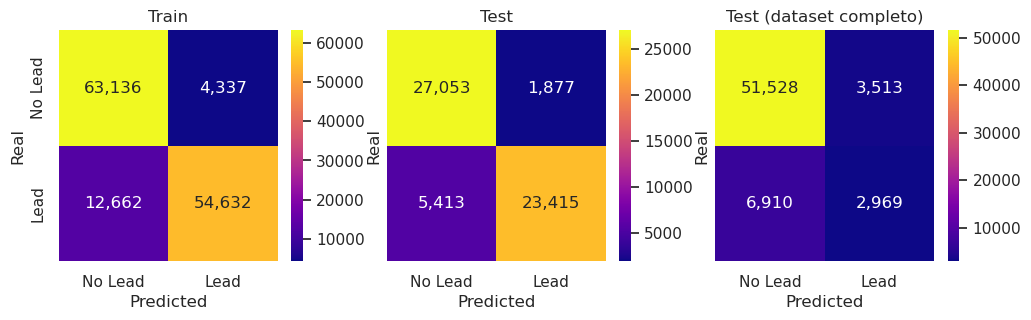

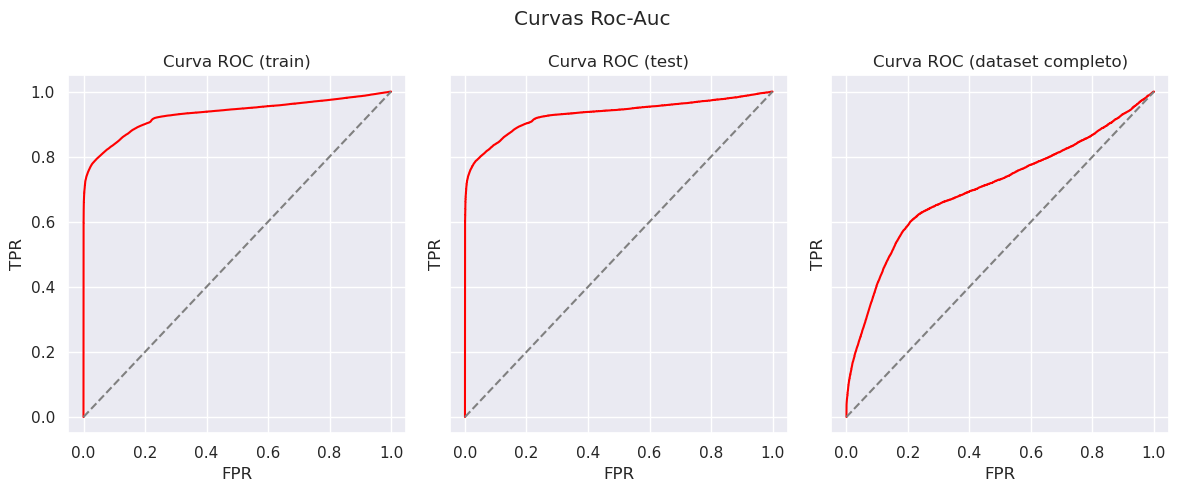

Classifier           Data    Acc  Recall  \
0  <class 'sklearn.svm._classes.SVC'>          Train  0.874   0.812   
1  <class 'sklearn.svm._classes.SVC'>           Test  0.874   0.812   
2  <class 'sklearn.svm._classes.SVC'>  Test RESERVED  0.839   0.301   

   Precision     F1   Roc-Auc  
0      0.926  0.865  0.931311  
1      0.926  0.865  0.930631  
2      0.458  0.363  0.703053

In [54]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Fracción de datos utlizados para set inicial de entrenamiento:", DATA_FRACTION*100,'%')
print()
print('Datos usados para entrenamiento (originales, subsampled, oversampled):',DATA_TO_USE)
print('X_train: {:,d}, X_test: {:,d}, y_train: {:,d}, y_test: {:,d}'.format(X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0]))
print()
print('Tiempo para fit operations:',round((duration)/60,2),'minutos')
print()
print("Componentes principales utlizados",maxPC,f'({capturedVarThreshold*100}% de la varianza)')
print()
print("Mejor accuracy gridSearch:", round(best_accuracy,4))
print()
print("Hiperparámetros del mejor modelo de gridsearch:")
print(best_parameters)
print()
print('Pasos del pipeline:')
for s in [str(step) for step in pipe.steps]: print('\t',s)
print()

# creamos un figura con tres subplots (train, test, test original)
target_labels = ['No Lead','Lead']
fig, axes = plt.subplots(1, 3, figsize=(12, 3),sharey=True)


figR, axesR = plt.subplots(1, 3, figsize=(12, 5),sharey=True)


# train
y_pred = best_model.predict(X_train)
y_pred_proba = best_model.predict_proba(X_train)[:, 1]
pmScoreTrain=round(best_model.score(X_train,y_train),3)
pmAccuracyTrain=round(accuracy_score(y_train,y_pred),3)
pmRecallTrain=round(recall_score(y_train,y_pred),3)
pmPrecisionTrain=round(precision_score(y_train,y_pred),3)
pmF1Train=round(f1_score(y_train,y_pred),3)
pmRocAucTrain = roc_auc_score(y_train, y_pred_proba)

cm = confusion_matrix(y_train,y_pred)
ax=axes[0]
sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',xticklabels=target_labels,yticklabels=target_labels,ax=ax)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
ax.set_title('Train')

ax=axesR[0]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
#plt.figure()
ax.set_title("Curva ROC (train)") 
ax.plot(fpr,tpr,color='red')
ax.plot([0,1],[0,1],linestyle='--',color='gray')
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

    
    
    
    
    
# test
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
pmScoreTest=round(best_model.score(X_test,y_test),3)
pmAccuracyTest=round(accuracy_score(y_test,y_pred),3)
pmRecallTest=round(recall_score(y_test,y_pred),3)
pmPrecisionTest=round(precision_score(y_test,y_pred),3)
pmF1Test=round(f1_score(y_test,y_pred),3)
pmRocAucTest = roc_auc_score(y_test, y_pred_proba)

cm = confusion_matrix(y_test,y_pred)
ax=axes[1]
sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',xticklabels=target_labels,yticklabels=target_labels,ax=ax)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
ax.set_title('Test')

ax=axesR[1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
#plt.figure()
ax.set_title("Curva ROC (test)") 
ax.plot(fpr,tpr,color='red')
ax.plot([0,1],[0,1],linestyle='--',color='gray')
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")









# test con los datos de prueba RESERVED:
y_pred = best_model.predict(X_TEST_RESERVED)
y_pred_proba = best_model.predict_proba(X_TEST_RESERVED)[:, 1]
pmScoreTestOrig=round(best_model.score(X_TEST_RESERVED,y_TEST_RESERVED),3)
pmAccuracyTestOrig=round(accuracy_score(y_TEST_RESERVED,y_pred),3)
pmRecallTestOrig=round(recall_score(y_TEST_RESERVED,y_pred),3)
pmPrecisionTestOrig=round(precision_score(y_TEST_RESERVED,y_pred),3)
pmF1TestOrig=round(f1_score(y_TEST_RESERVED, y_pred),3)
pmRocAucTestOrig = roc_auc_score(y_TEST_RESERVED, y_pred_proba)

cm = confusion_matrix(y_TEST_RESERVED,y_pred)
ax=axes[2]
sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',xticklabels=target_labels,yticklabels=target_labels,ax=ax)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
ax.set_title('Test (dataset completo)')

ax=axesR[2]
fpr, tpr, thresholds = roc_curve(y_TEST_RESERVED, y_pred_proba)
#plt.figure()
ax.set_title("Curva ROC (dataset completo)") 
ax.plot(fpr,tpr,color='red')
ax.plot([0,1],[0,1],linestyle='--',color='gray')
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")







#fig.suptitle('Matrices de confusión')
figR.suptitle('Curvas Roc-Auc')
plt.tight_layout()
plt.show()












classifiersPerformances.loc[len(classifiersPerformances.index)] = [type(pipe['classifier']),'Train',
                                                                  pmAccuracyTrain, pmRecallTrain, pmPrecisionTrain, pmF1Train,pmRocAucTrain
                                                                  ] 

classifiersPerformances.loc[len(classifiersPerformances.index)] = [type(pipe['classifier']),'Test',
                                                                  pmAccuracyTest, pmRecallTest, pmPrecisionTest, pmF1Test,pmRocAucTest
                                                                  ] 

classifiersPerformances.loc[len(classifiersPerformances.index)] = [type(pipe['classifier']),'Test RESERVED',
                                                                  pmAccuracyTestOrig, pmRecallTestOrig, pmPrecisionTestOrig, pmF1TestOrig,pmRocAucTestOrig
                                                                  ] 

display(classifiersPerformances)

if type(classifier) == type(RandomForestClassifier(n_jobs=-1)):
    if SCALER:
        X_train_scaled = scaler.fit_transform(X_train)
        X_train = X_train_scaled
        
    if DIMRED:
        pca = PCA(n_components=maxPC)
        X_train_red = pca.fit_transform(X_train)
        X_train = X_train_red
    
    feature_cols = pd.DataFrame(X_train_red).columns.to_list()
    classifier.fit(X_train,y_train)
    
    importances = pd.DataFrame({'feature':feature_cols,'importancia':np.round(classifier.feature_importances_,3)})
    importances.sort_values(by='importancia',ascending=False,inplace=True)
    importances.set_index('feature')
    print(importances)



### Clustering con DBSCAN

In [55]:
# usando datos originales (sin resample)
print(data.shape)
X = data.drop('Is_Lead',axis=1)
y = data['Is_Lead']

modelo = DBSCAN(eps=1000, min_samples=300)
yhat = modelo.fit_predict(X)
clusters = [j for j in np.unique(yhat) if j!=-1]
print(clusters)

(151480, 50)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]


Clientes que no fueron agregados a un cluster: 132841 / 151480


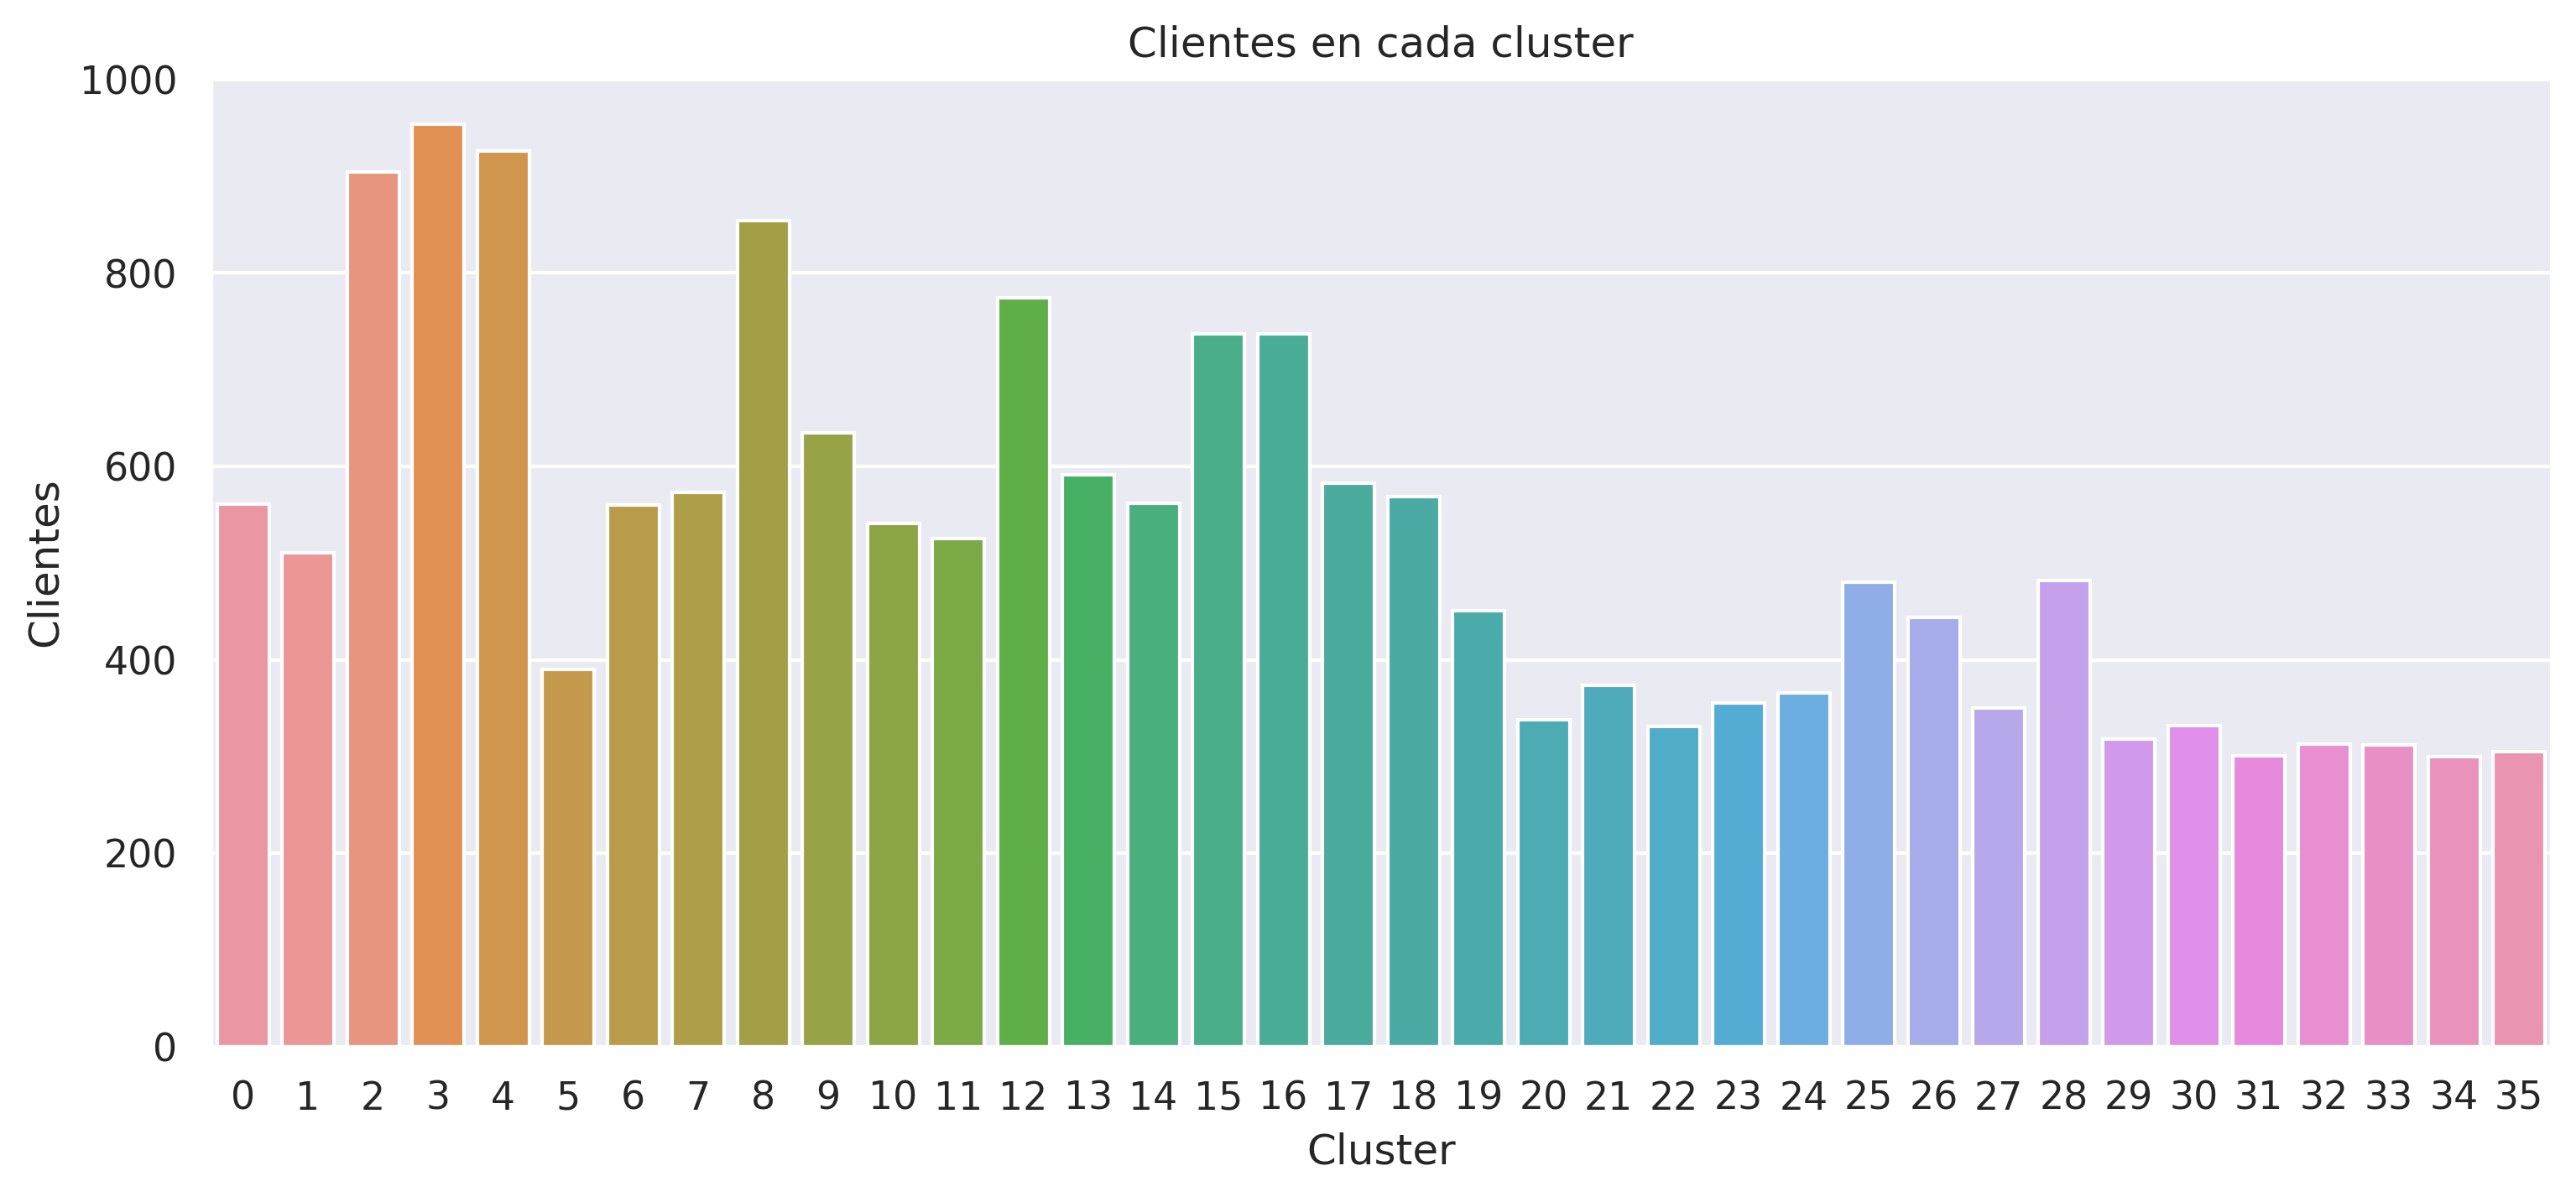

El total de clientes en clusters es de: 18639
Estadísticas descriptivas del cluster 6:


Age     Vintage  Avg_Account_Balance  Gender_Male  \
count  560.000000  560.000000           560.000000   560.000000   
mean    41.041071   40.533929        554861.698214     0.533929   
std     13.750918   29.025353          1070.133926     0.499294   
min     24.000000    7.000000        552939.000000     0.000000   
25%     29.000000   19.750000        553971.000000     0.000000   
50%     38.000000   27.000000        554843.000000     1.000000   
75%     50.000000   56.250000        555744.250000     1.000000   
max     85.000000  128.000000        556721.000000     1.000000   

       Occupation_Entrepreneur  Occupation_Other  Occupation_Salaried  \
count               560.000000        560.000000           560.000000   
mean                  0.008929          0.232143             0.326786   
std                   0.094152          0.422577             0.469458   
min                   0.000000          0.000000             0.000000   
25%                   0.000000          0.000000             0.000000   
50%                   0.000000          0.000000             0.000000   
75%                   0.000000          0.000000             1.000000   
max                   1.000000          1.000000             1.000000   

       Occupation_Self_Employed  Is_Active_Yes  Credit_Product_Yes  ...  \
count                560.000000     560.000000          560.000000  ...   
mean                   0.432143       0.339286            0.319643  ...   
std                    0.495817       0.473890            0.466755  ...   
min                    0.000000       0.000000            0.000000  ...   
25%                    0.000000       0.000000            0.000000  ...   
50%                    0.000000       0.000000            0.000000  ...   
75%                    1.000000       1.000000            1.000000  ...   
max                    1.000000       1.000000            1.000000  ...   

       Region_Code_RG277  Region_Code_RG278  Region_Code_RG279  \
count          560.00000         560.000000         560.000000   
mean             0.05000           0.003571           0.021429   
std              0.21814           0.059708           0.144938   
min              0.00000           0.000000           0.000000   
25%              0.00000           0.000000           0.000000   
50%              0.00000           0.000000           0.000000   
75%              0.00000           0.000000           0.000000   
max              1.00000           1.000000           1.000000   

       Region_Code_RG280  Region_Code_RG281  Region_Code_RG282  \
count         560.000000         560.000000         560.000000   
mean            0.066071           0.025000           0.019643   
std             0.248629           0.156265           0.138894   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.000000           0.000000           0.000000   
75%             0.000000           0.000000           0.000000   
max             1.000000           1.000000           1.000000   

       Region_Code_RG283  Region_Code_RG284     Is_Lead  Cluster  
count         560.000000         560.000000  560.000000    560.0  
mean            0.041071           0.058929    0.133929      6.0  
std             0.198633           0.235702    0.340880      0.0  
min             0.000000           0.000000    0.000000      6.0  
25%             0.000000           0.000000    0.000000      6.0  
50%             0.000000           0.000000    0.000000      6.0  
75%             0.000000           0.000000    0.000000      6.0  
max             1.000000           1.000000    1.000000      6.0  

[8 rows x 51 columns]

In [56]:
# creamos un dataframe que incluye la featrues matrix junto con su clase (lead o no Lead) y su cluster
# que usaremos solo par explorar los datos, estas dos nuevas columnas no intervinieron en el clustering
XWithYAndCluster = pd.concat((X.reset_index(drop=True),y.reset_index(drop=True),pd.DataFrame(yhat,columns=['Cluster'])), axis=1)

print("Clientes que no fueron agregados a un cluster:",XWithYAndCluster[XWithYAndCluster.Cluster==-1].shape[0],'/',XWithYAndCluster.shape[0])

clientesEnClustersTotales=0
clientesEnClusters=[]
for cluster in clusters:
    clientesEnClusters.append( XWithYAndCluster[XWithYAndCluster.Cluster==cluster].shape[0] )
    clientesEnClustersTotales += XWithYAndCluster[XWithYAndCluster.Cluster==cluster].shape[0]

plt.figure(figsize=(12,5), dpi=300)
sns.barplot(x=np.arange(len(clientesEnClusters)), y=clientesEnClusters)
plt.xlabel("Cluster")
plt.ylabel("Clientes")
plt.title("Clientes en cada cluster")
plt.show()

print('El total de clientes en clusters es de:',clientesEnClustersTotales)
#display(XWithYAndCluster.head())

printClusterNumber = 6
print(f'Estadísticas descriptivas del cluster {printClusterNumber}:')
display(XWithYAndCluster[XWithYAndCluster.Cluster==printClusterNumber].describe())



**Observaciones:**

Los clientes dentro de cada cluster deben tener características similares. Revisando las desviaciones estándar de cada feature podemos hacernos cierta idea de las features que comparten:

#### Desviación estándar de cada feature de los datos del un par de clusters:

In [57]:
clusterNumber = printClusterNumber
stds=XWithYAndCluster[(XWithYAndCluster.Cluster==clusterNumber)]
stds.describe().loc['std'].sort_values()

Cluster                        0.000000
Region_Code_RG278              0.059708
Region_Code_RG271              0.059708
Region_Code_RG262              0.073061
Region_Code_RG253              0.073061
Region_Code_RG276              0.084288
Occupation_Entrepreneur        0.094152
Region_Code_RG267              0.094152
Region_Code_RG266              0.103046
Region_Code_RG256              0.118772
Region_Code_RG250              0.118772
Region_Code_RG259              0.132551
Region_Code_RG264              0.132551
Region_Code_RG258              0.132551
Region_Code_RG282              0.138894
Region_Code_RG265              0.138894
Region_Code_RG275              0.138894
Region_Code_RG273              0.138894
Region_Code_RG255              0.138894
Region_Code_RG279              0.144938
Region_Code_RG263              0.144938
Region_Code_RG281              0.156265
Region_Code_RG260              0.156265
Channel_Code_X4                0.166748
Region_Code_RG272              0.176537


In [58]:
clusterNumber = 4
stds=XWithYAndCluster[(XWithYAndCluster.Cluster==clusterNumber)]
stds.describe().loc['std'].sort_values()

Cluster                        0.000000
Region_Code_RG271              0.046449
Occupation_Entrepreneur        0.065617
Region_Code_RG255              0.073323
Region_Code_RG253              0.073323
Region_Code_RG265              0.080277
Region_Code_RG278              0.086662
Region_Code_RG262              0.092596
Region_Code_RG266              0.092596
Region_Code_RG258              0.092596
Region_Code_RG260              0.108400
Region_Code_RG259              0.113159
Region_Code_RG250              0.122091
Region_Code_RG267              0.122091
Region_Code_RG256              0.126307
Region_Code_RG264              0.134317
Region_Code_RG263              0.134317
Region_Code_RG252              0.138135
Region_Code_RG276              0.141842
Region_Code_RG281              0.141842
Region_Code_RG251              0.141842
Region_Code_RG273              0.148956
Region_Code_RG275              0.152377
Region_Code_RG272              0.155715
Region_Code_RG279              0.162165


### Clustering con Jerárquico usando PCA

In [59]:
# usando datos originales (sin resample)
print(data.shape)
X = data.drop('Is_Lead',axis=1)
y = data['Is_Lead']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_red = pca.fit_transform(X_scaled)

explained_variance_ratios = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratios)
for i in range(2):
    print(f"Varianza explicada para el componente {i+1}: {explained_variance_ratios[i]}")
print(f"Varianza acumulada para {2} componentes: {cumulative_variance[2-1]}")

modelo = AgglomerativeClustering(distance_threshold=5.0,
                                 n_clusters=None,
                                 compute_full_tree=True)

yhat = modelo.fit_predict(X_red)
clusters = [j for j in np.unique(yhat) if j!=-1]
print("Clusters:")
print(clusters)

(151480, 50)
Varianza explicada para el componente 1: 0.22329837823888757
Varianza explicada para el componente 2: 0.10824442235409366
Varianza acumulada para 2 componentes: 0.33154280059298125
Clusters:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


Clientes que no fueron agregados a un cluster: 0 / 151480


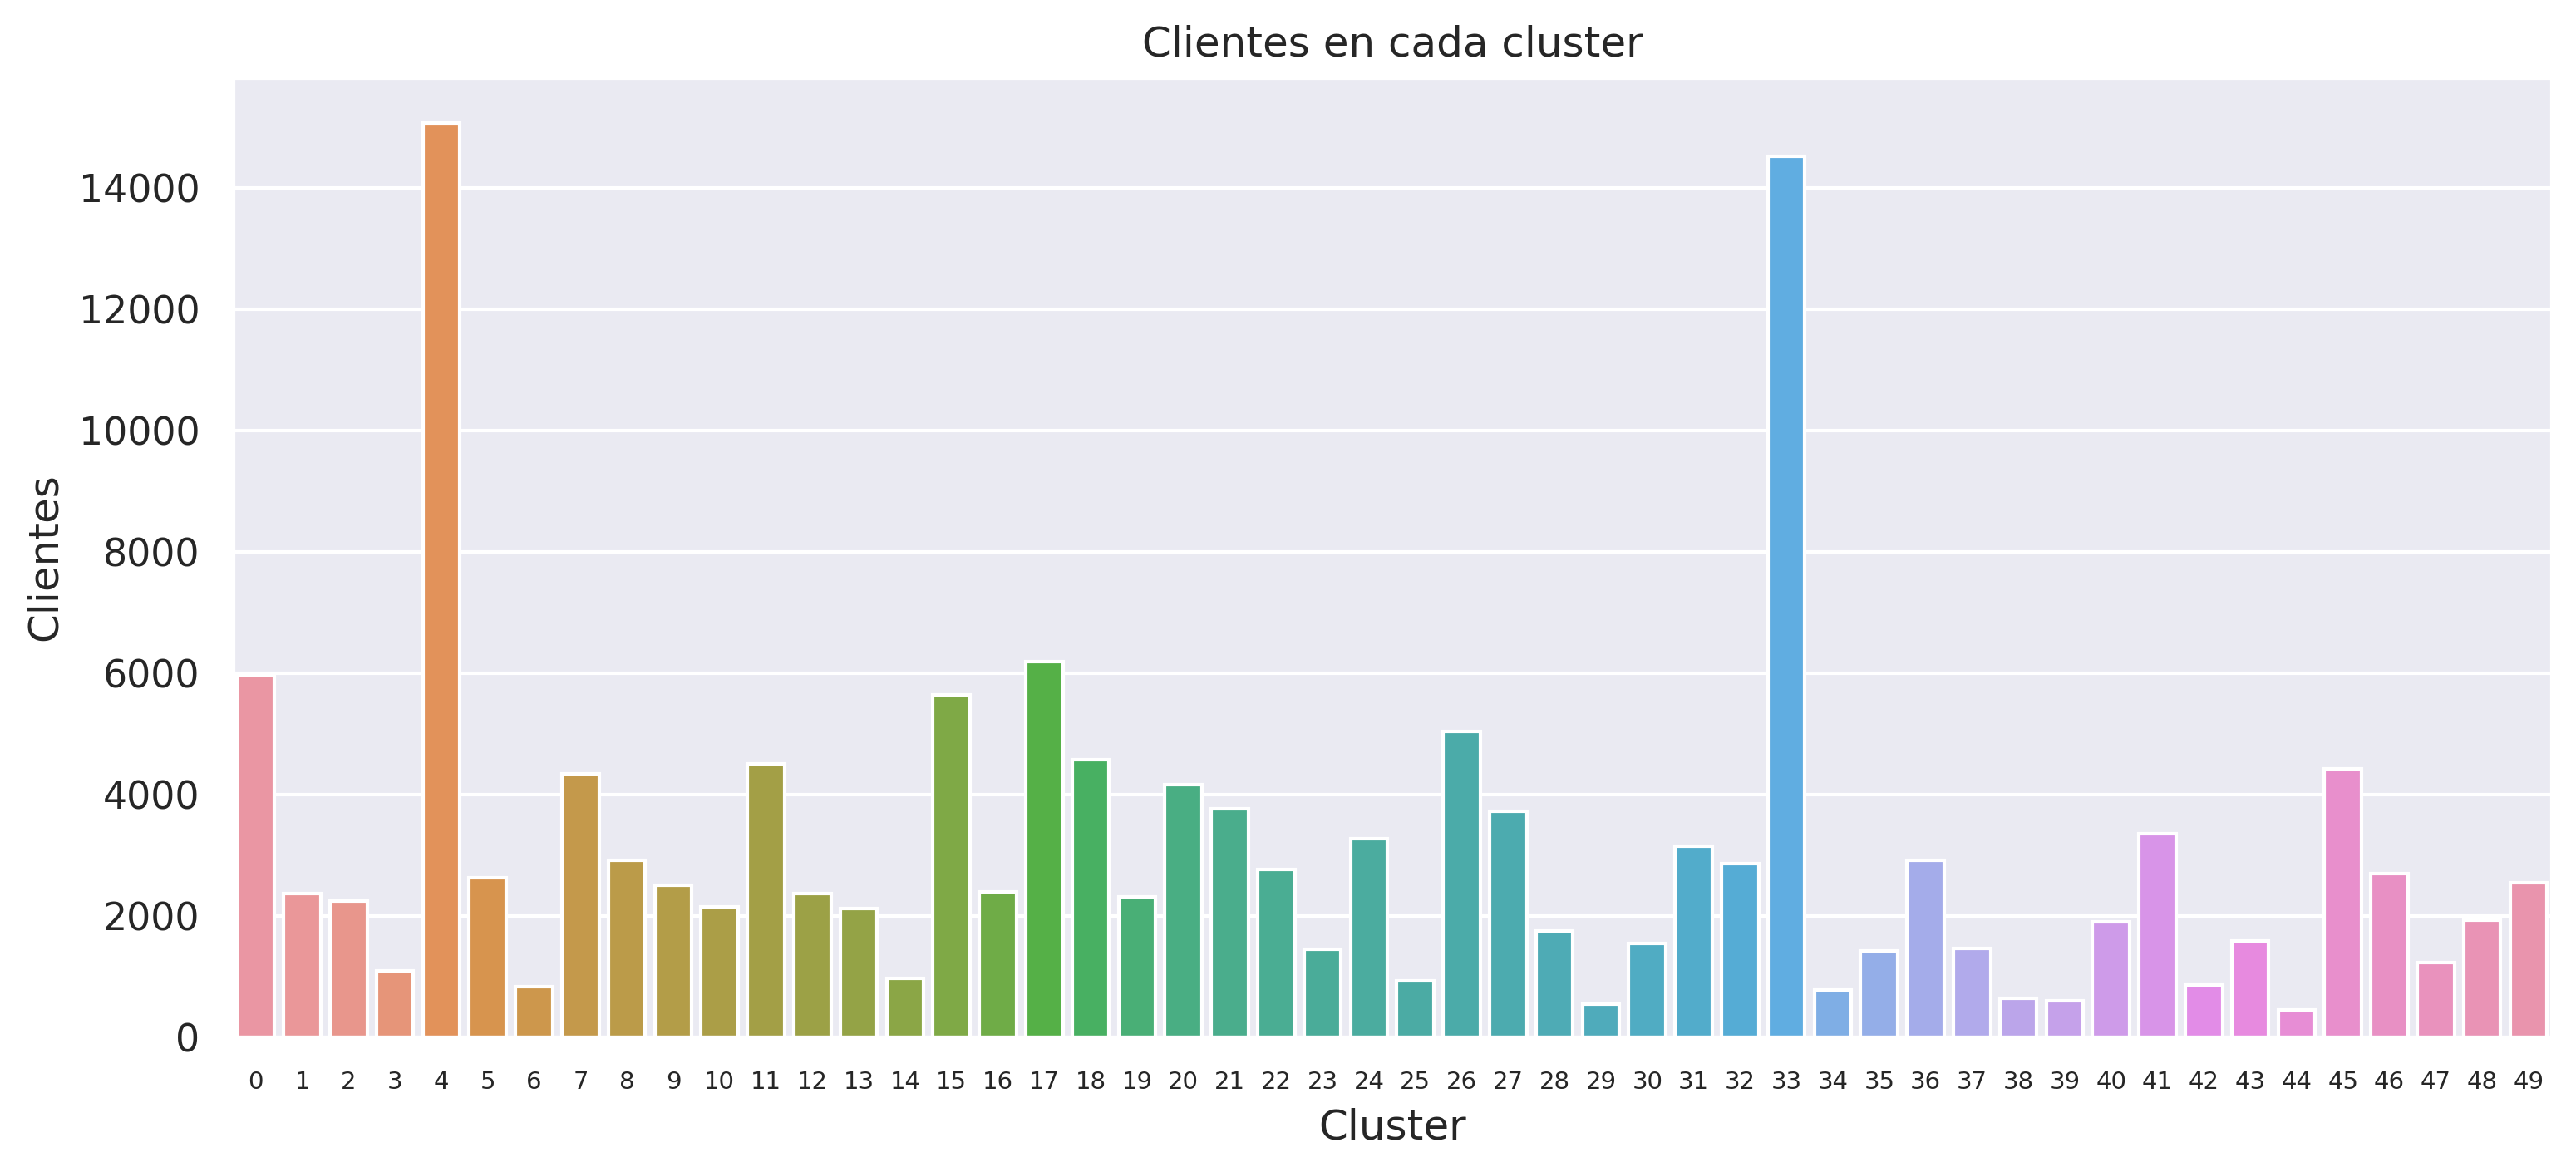

El total de clientes en clusters es de: 151480
Estadísticas descriptivas del cluster 6:


Age     Vintage  Avg_Account_Balance  Gender_Male  \
count  837.000000  837.000000         8.370000e+02   837.000000   
mean    50.492234   82.223417         1.483578e+06     0.788530   
std      9.182571   34.451047         1.031209e+06     0.408595   
min     25.000000    7.000000         1.537560e+05     0.000000   
25%     45.000000   61.000000         7.839030e+05     1.000000   
50%     51.000000   92.000000         1.200930e+06     1.000000   
75%     58.000000  109.000000         1.840092e+06     1.000000   
max     64.000000  129.000000         7.577219e+06     1.000000   

       Occupation_Entrepreneur  Occupation_Other  Occupation_Salaried  \
count               837.000000             837.0           837.000000   
mean                  0.077658               0.0             0.922342   
std                   0.267793               0.0             0.267793   
min                   0.000000               0.0             0.000000   
25%                   0.000000               0.0             1.000000   
50%                   0.000000               0.0             1.000000   
75%                   0.000000               0.0             1.000000   
max                   1.000000               0.0             1.000000   

       Occupation_Self_Employed  Is_Active_Yes  Credit_Product_Yes  ...  \
count                     837.0     837.000000          837.000000  ...   
mean                        0.0       0.640382            0.911589  ...   
std                         0.0       0.480175            0.284061  ...   
min                         0.0       0.000000            0.000000  ...   
25%                         0.0       0.000000            1.000000  ...   
50%                         0.0       1.000000            1.000000  ...   
75%                         0.0       1.000000            1.000000  ...   
max                         0.0       1.000000            1.000000  ...   

       Region_Code_RG277  Region_Code_RG278  Region_Code_RG279  \
count         837.000000         837.000000         837.000000   
mean            0.047790           0.010753           0.021505   
std             0.213449           0.103198           0.145148   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.000000           0.000000           0.000000   
75%             0.000000           0.000000           0.000000   
max             1.000000           1.000000           1.000000   

       Region_Code_RG280  Region_Code_RG281  Region_Code_RG282  \
count         837.000000         837.000000         837.000000   
mean            0.032258           0.009558           0.013142   
std             0.176790           0.097355           0.113952   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.000000           0.000000           0.000000   
75%             0.000000           0.000000           0.000000   
max             1.000000           1.000000           1.000000   

       Region_Code_RG283  Region_Code_RG284     Is_Lead  Cluster  
count         837.000000         837.000000  837.000000    837.0  
mean            0.201912           0.117085    0.888889      6.0  
std             0.401667           0.321714    0.314458      0.0  
min             0.000000           0.000000    0.000000      6.0  
25%             0.000000           0.000000    1.000000      6.0  
50%             0.000000           0.000000    1.000000      6.0  
75%             0.000000           0.000000    1.000000      6.0  
max             1.000000           1.000000    1.000000      6.0  

[8 rows x 51 columns]

In [60]:
# creamos un dataframe que incluye la featrues matrix junto con su clase (lead o no Lead) y su cluster
# que usaremos solo par explorar los datos, estas dos nuevas columnas no intervinieron en el clustering
XWithYAndCluster = pd.concat((X.reset_index(drop=True),y.reset_index(drop=True),pd.DataFrame(yhat,columns=['Cluster'])), axis=1)

print("Clientes que no fueron agregados a un cluster:",XWithYAndCluster[XWithYAndCluster.Cluster==-1].shape[0],'/',XWithYAndCluster.shape[0])

clientesEnClustersTotales=0
clientesEnClusters=[]
for cluster in clusters:
    clientesEnClusters.append( XWithYAndCluster[XWithYAndCluster.Cluster==cluster].shape[0] )
    clientesEnClustersTotales += XWithYAndCluster[XWithYAndCluster.Cluster==cluster].shape[0]

plt.figure(figsize=(12,5),dpi=300)
sns.barplot(x=np.arange(len(clientesEnClusters)), y=clientesEnClusters)
plt.xticks(fontsize=7)
plt.xlabel("Cluster")
plt.ylabel("Clientes")
plt.title("Clientes en cada cluster")
plt.show()

print('El total de clientes en clusters es de:',clientesEnClustersTotales)
#display(XWithYAndCluster.head())
print('Estadísticas descriptivas del cluster 6:')
display(XWithYAndCluster[XWithYAndCluster.Cluster==6].describe())


#### Desviación estándar de cada feature de un cluster:

In [61]:
clusterNumber = 7
stds=XWithYAndCluster[(XWithYAndCluster.Cluster==clusterNumber)]
stds.describe().loc['std'].sort_values()

Cluster                          0.000000
Channel_Code_X4                  0.000000
Occupation_Other                 0.000000
Occupation_Salaried              0.000000
Channel_Code_X1                  0.000000
Region_Code_RG267                0.045481
Region_Code_RG271                0.047935
Region_Code_RG256                0.054636
Region_Code_RG262                0.058675
Region_Code_RG258                0.064252
Region_Code_RG255                0.066005
Region_Code_RG250                0.067712
Region_Code_RG266                0.071001
Region_Code_RG264                0.072588
Region_Code_RG275                0.074141
Region_Code_RG265                0.074141
Region_Code_RG253                0.084194
Region_Code_RG252                0.089419
Region_Code_RG278                0.091917
Region_Code_RG263                0.093140
Region_Code_RG260                0.095538
Region_Code_RG259                0.101274
Region_Code_RG270                0.101274
Region_Code_RG261                0

**Observaciones:**

Podríamos encontrar qué cluster se basa más en cierta feature, Vintage, por ejemplo si comparamos la desviación estándar de cada cluster y encontramos cuál cluster tiene menos.

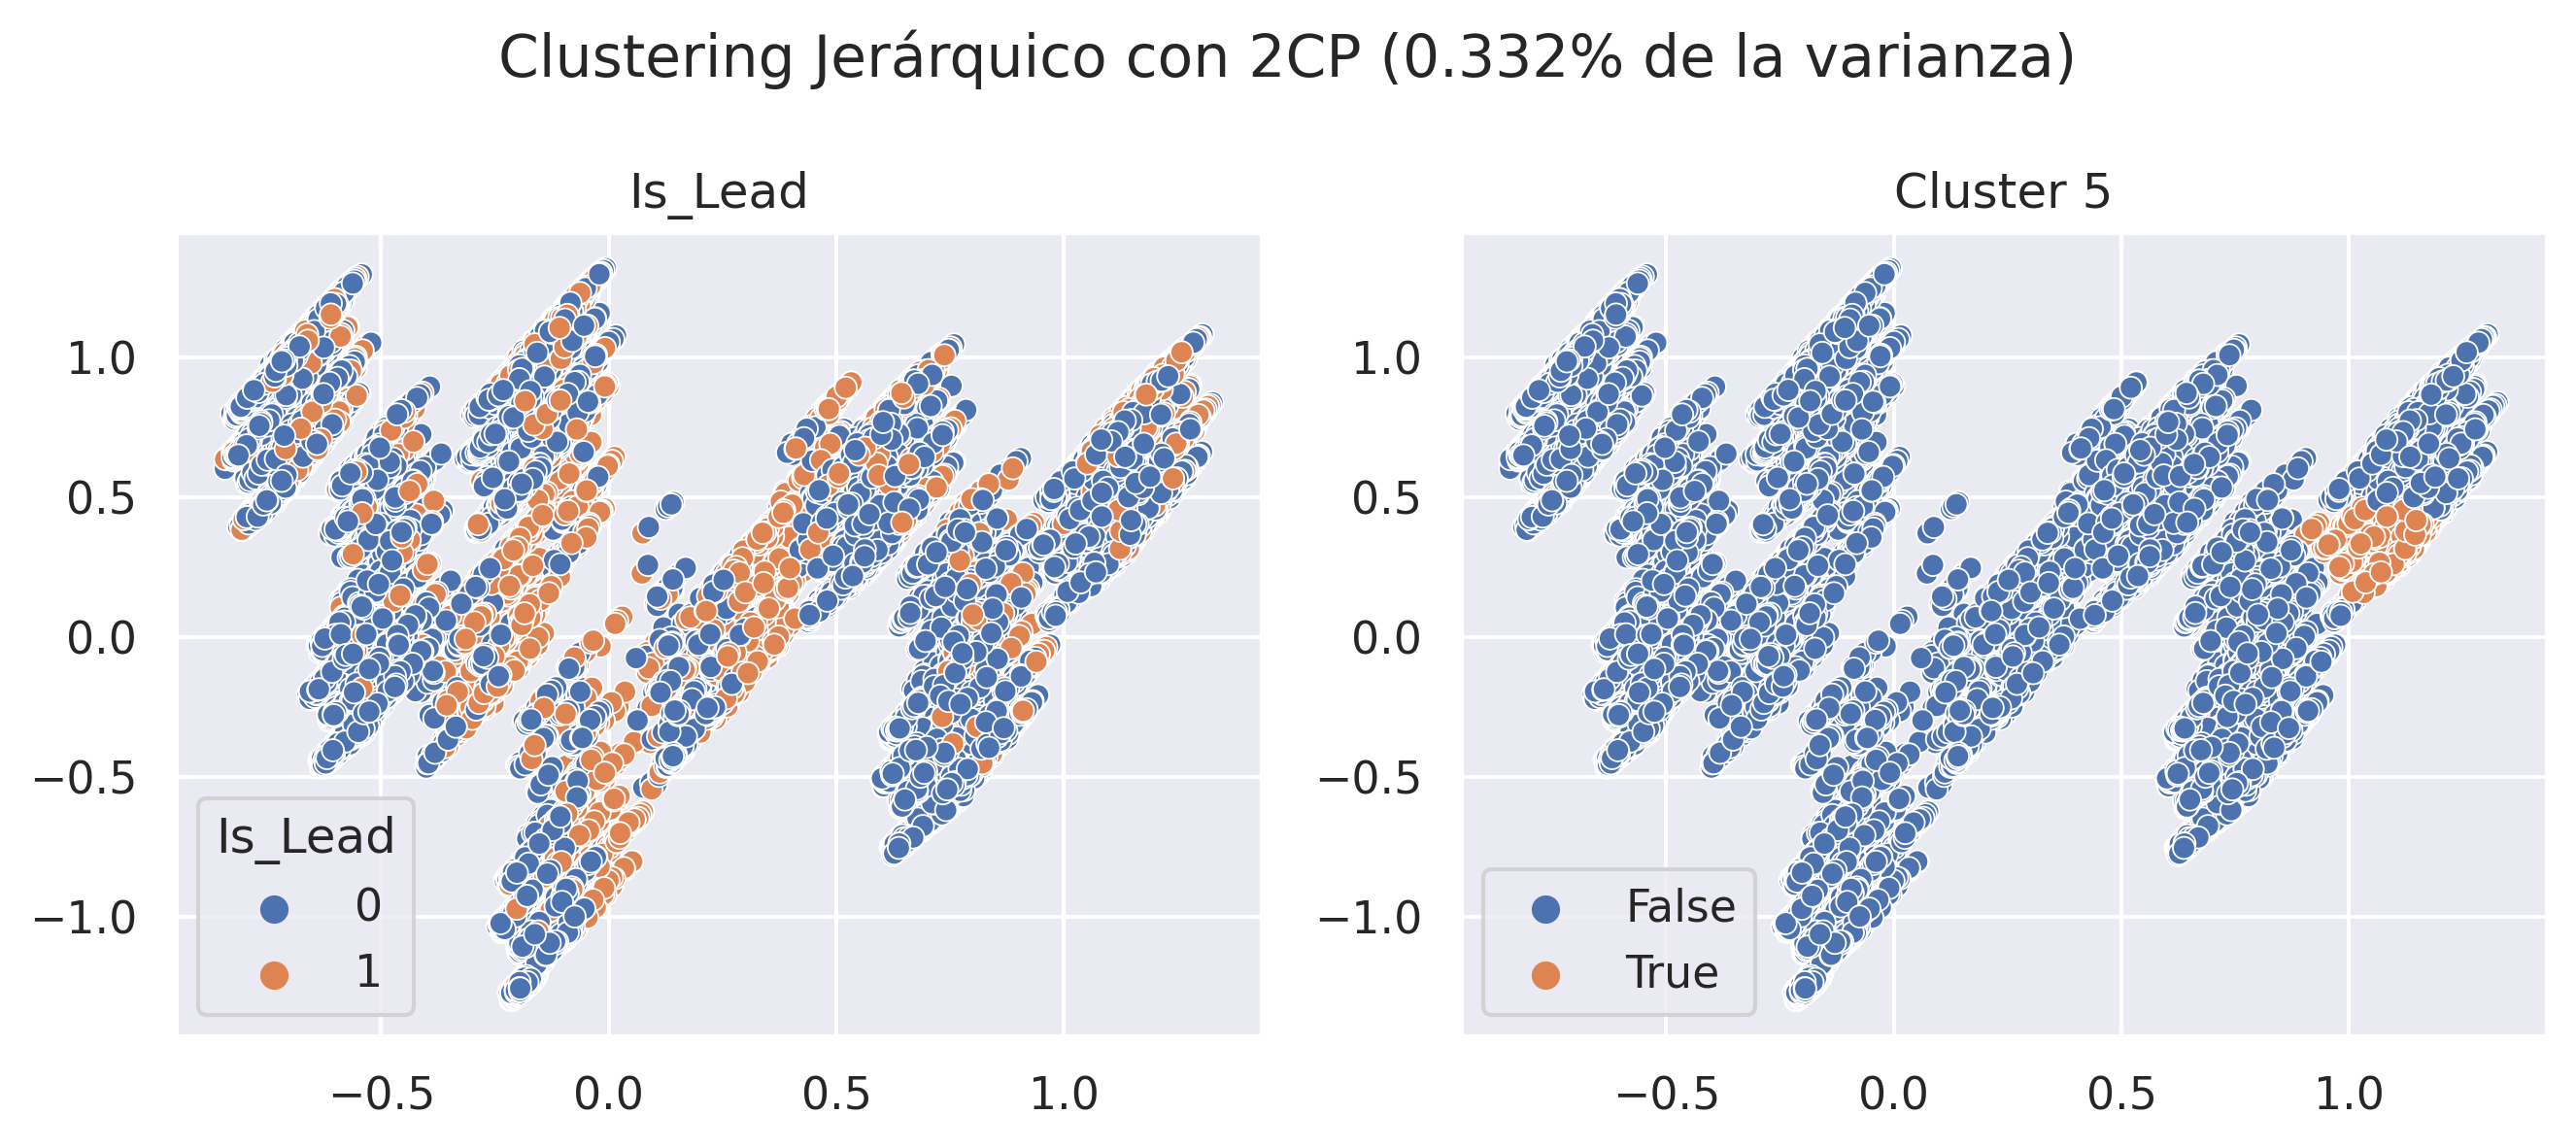

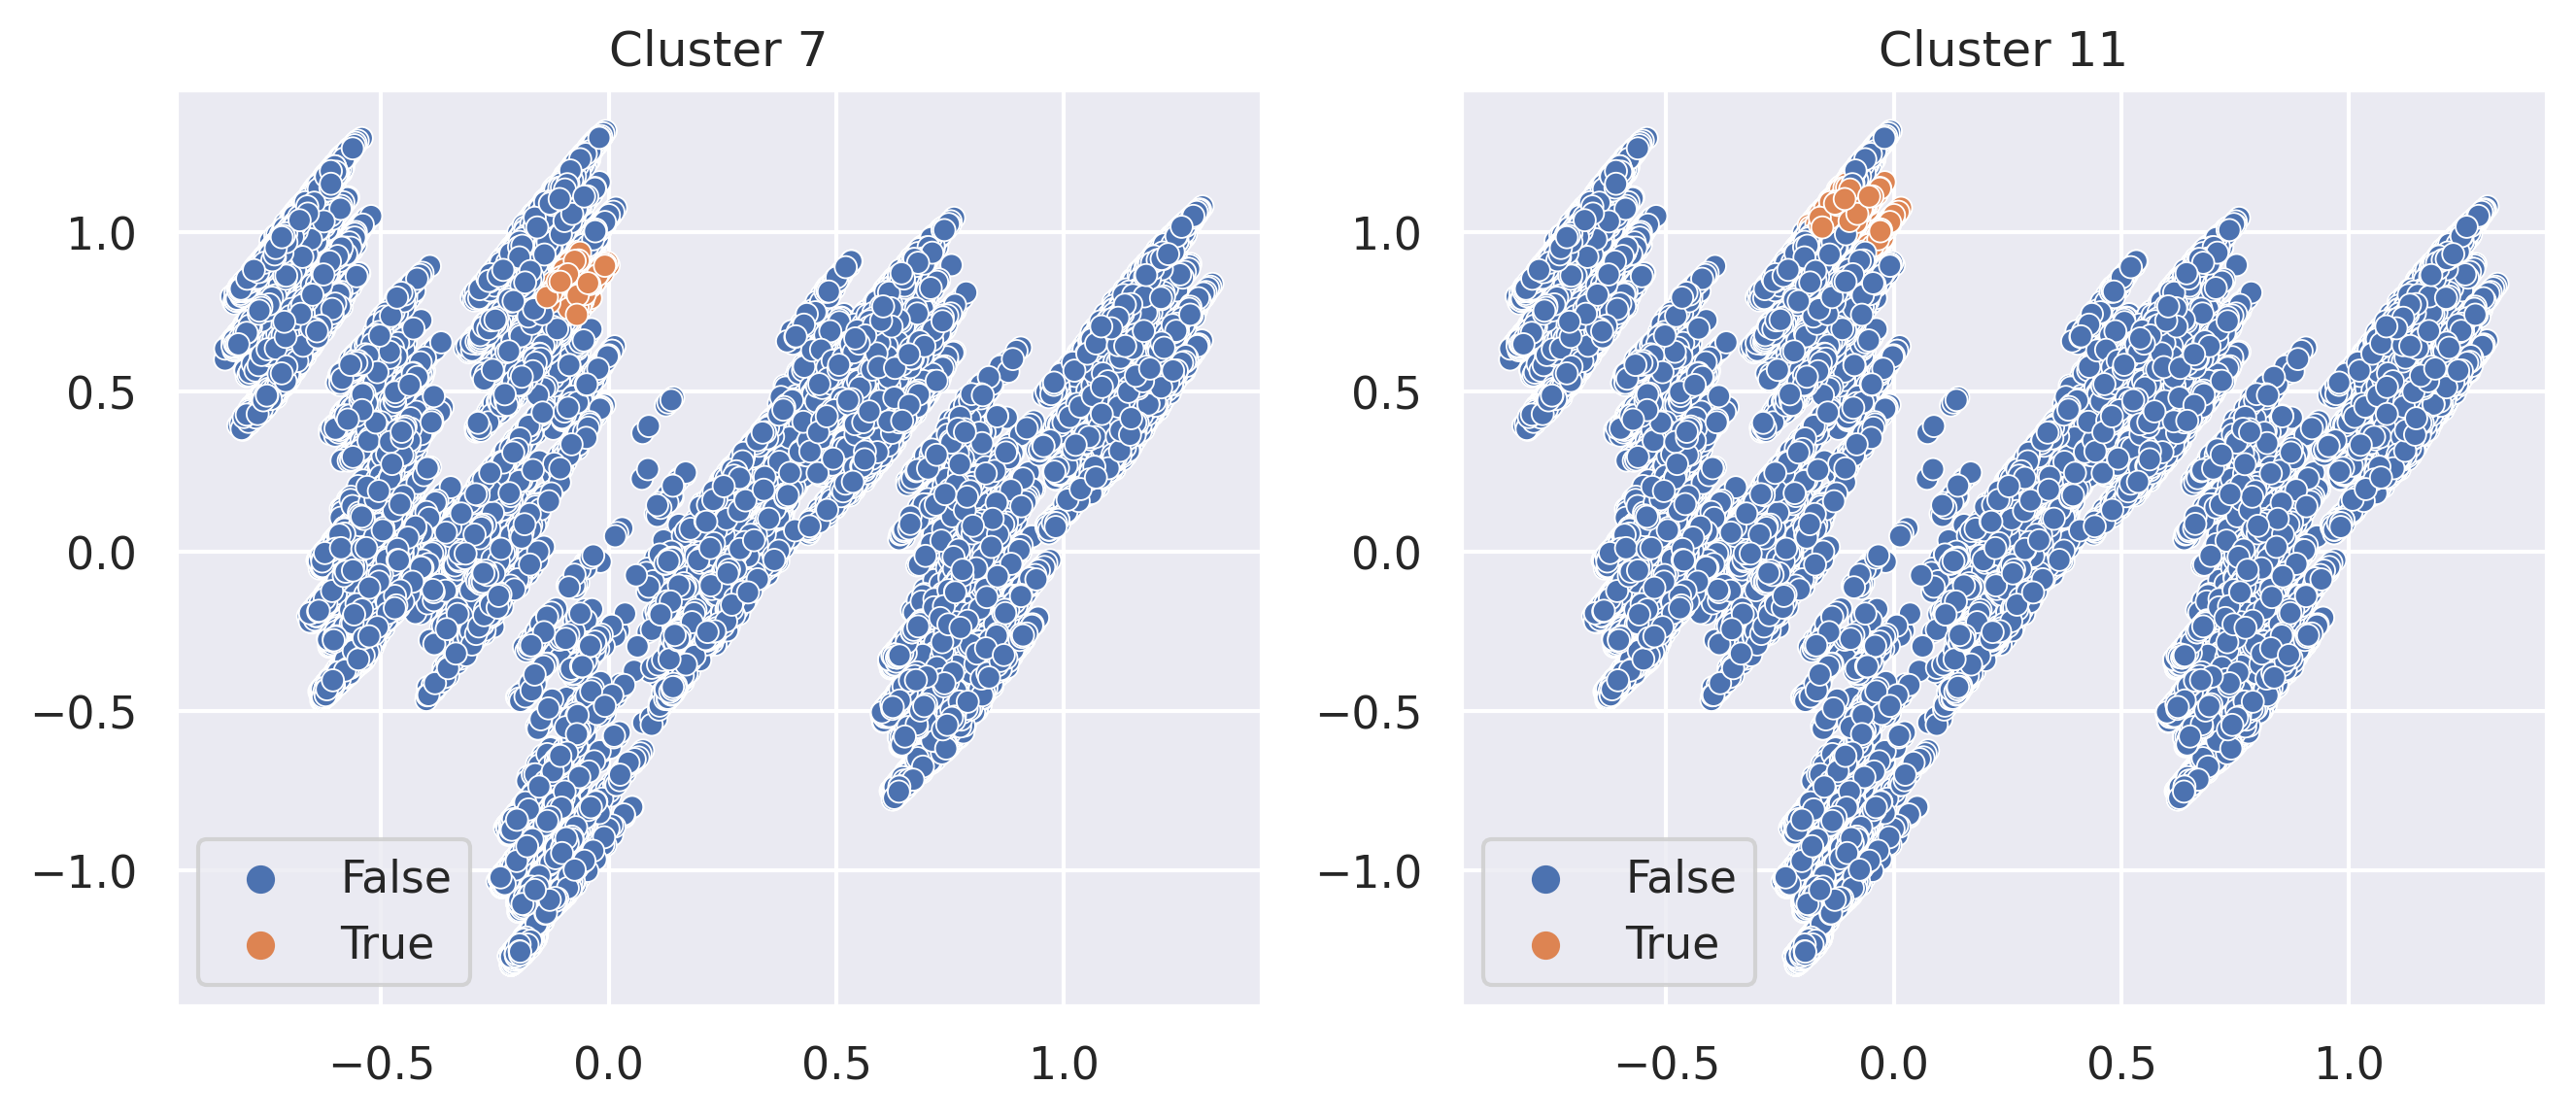

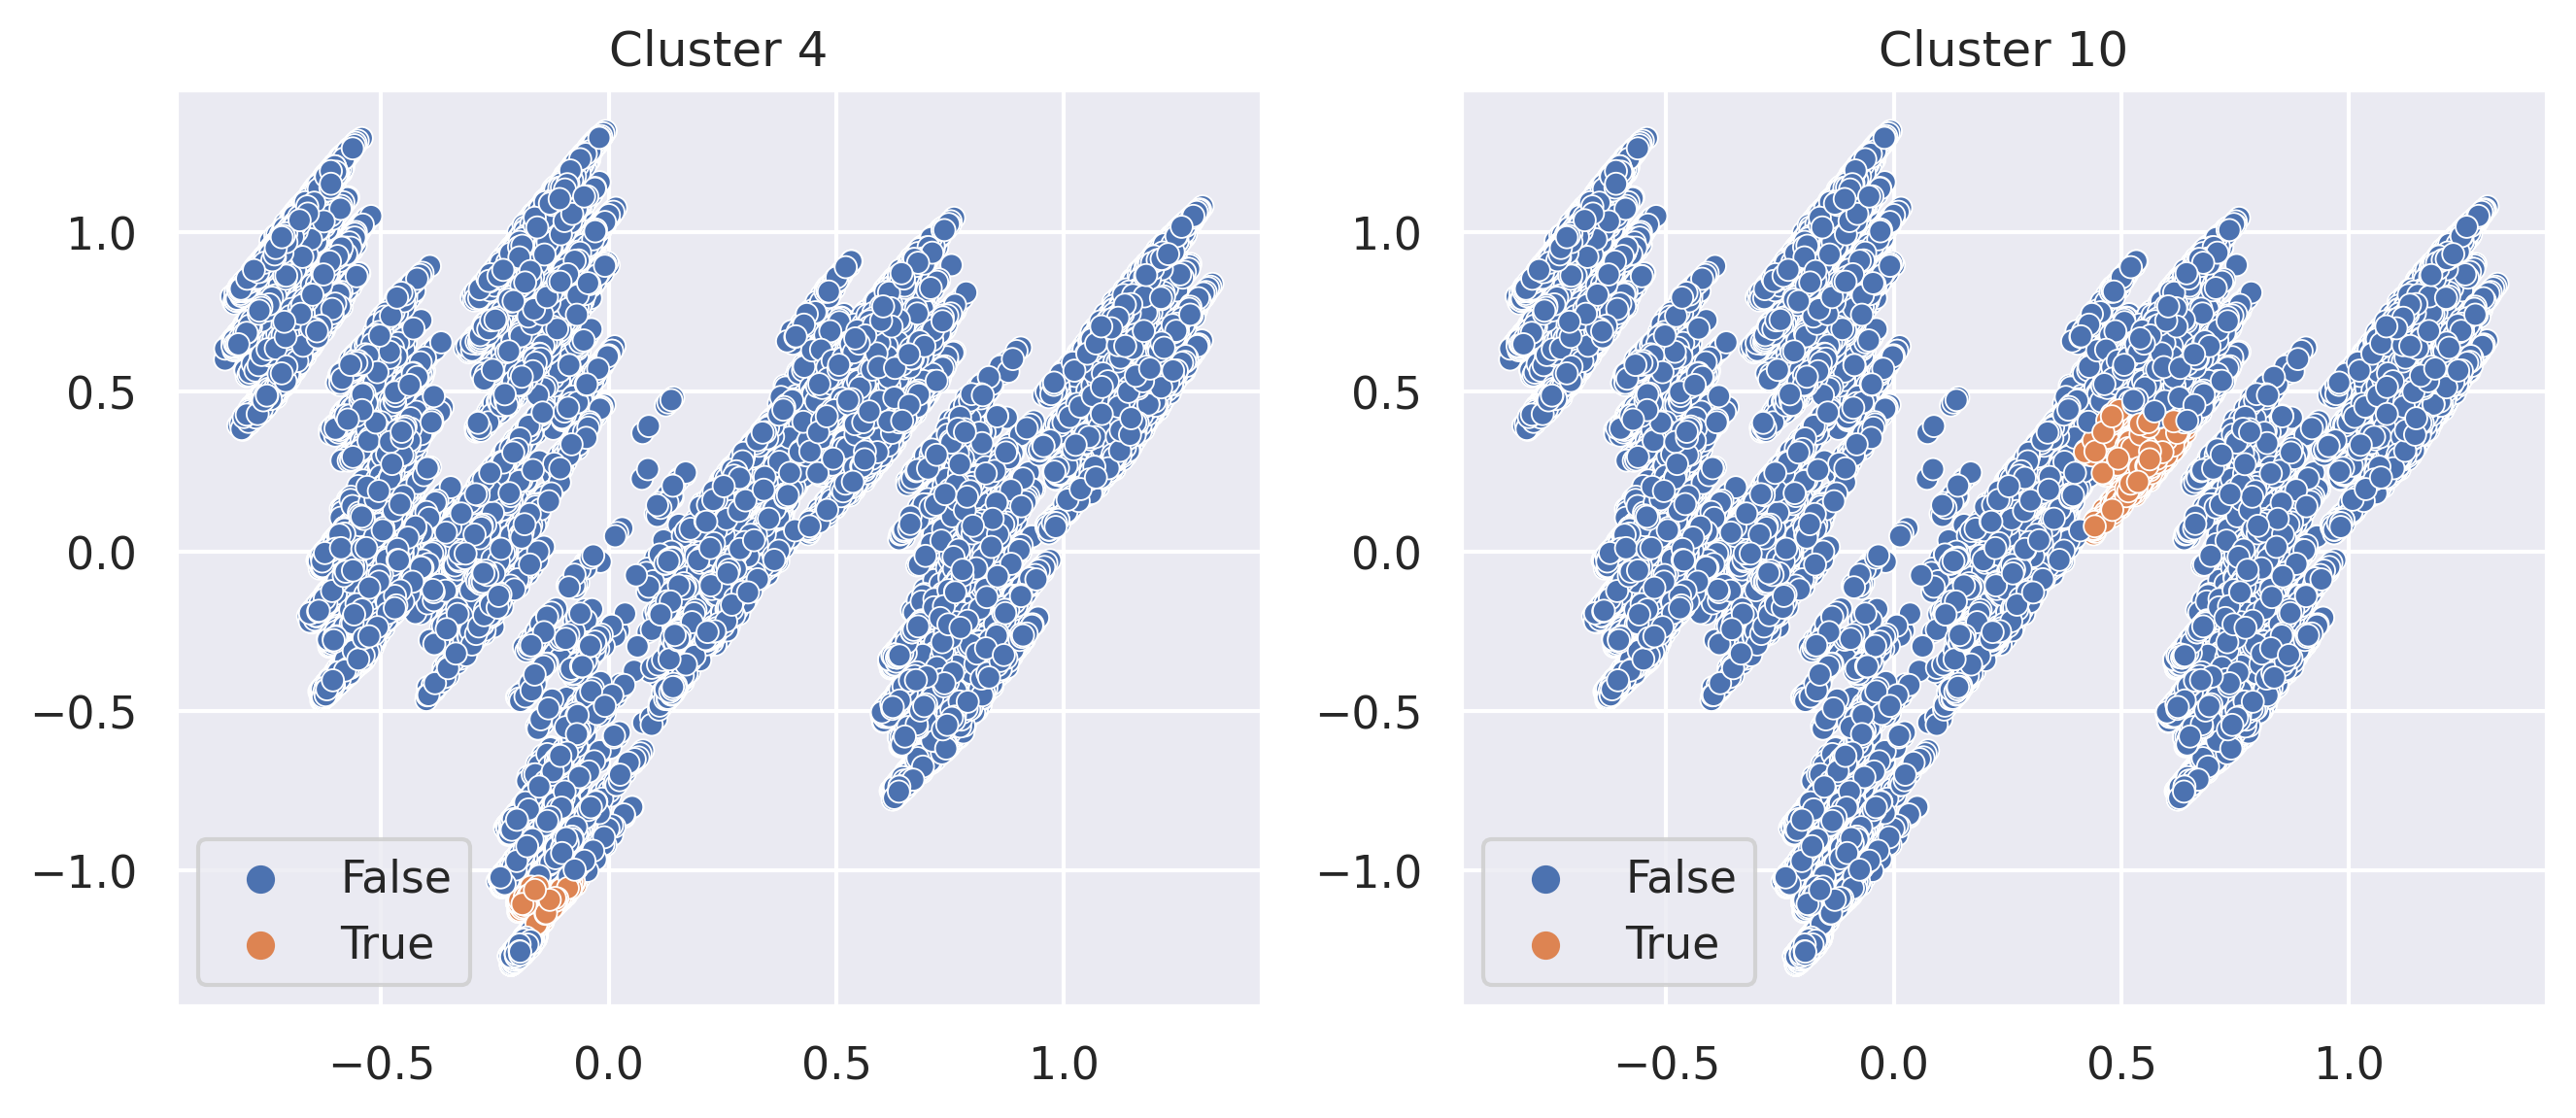

In [62]:
# plotting de clusters
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4),dpi=300)
sns.scatterplot(x = X_red[:,1], y = X_red[:,0], hue = y, palette='deep', ax=axes[0], s=30)
axes[0].set_title('Is_Lead')
sns.scatterplot(x = X_red[:,1], y = X_red[:,0], hue = yhat==5, palette='deep', ax=axes[1], s=30)
axes[1].set_title('Cluster 5')
plt.suptitle(f'Clustering Jerárquico con 2CP ({round(cumulative_variance[-1],3)}% de la varianza)')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4),dpi=300)
sns.scatterplot(x = X_red[:,1], y = X_red[:,0], hue = yhat==7, palette='deep', ax=axes[0], s=30)
axes[0].set_title('Cluster 7')
sns.scatterplot(x = X_red[:,1], y = X_red[:,0], hue = yhat==11, palette='deep', ax=axes[1], s=30)
axes[1].set_title('Cluster 11')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4),dpi=300)
sns.scatterplot(x = X_red[:,1], y = X_red[:,0], hue = yhat==4, palette='deep', ax=axes[0], s=30)
axes[0].set_title('Cluster 4')
sns.scatterplot(x = X_red[:,1], y = X_red[:,0], hue = yhat==10, palette='deep', ax=axes[1], s=30)
axes[1].set_title('Cluster 10')
plt.tight_layout()
plt.show()

## Conclusiones

El trabajo realizado fue de inmensa utilidad para comprender más la implementación de muchos modelos y técnicas vistas en el módulo dos del diplomado.

El análisis de cluster puede revelar conocimientos de los datos que en primera instancia están muy ocultos.

El tamaño del dataset es un factor principal a tomar en cuenta al acercarse a un problema donde pueda aplicarse ML y en el caso del trabajo aquí presentado fue una de las carácteríticas más dificil de tratar para llegar a buenos modelos de clasificación.

Es necesario consultar continuamente la documentación de las implementaciones en Python así como la teoría detrás de cada modelo y algoritmos para familiarizarse plenamente con la materia.

El dataset y planteamiento del problema fue parte de un job-a-ton. La tabla de ranking de soluciones de varias pesonas se encuentra en https://datahack.analyticsvidhya.com/contest/job-a-thon-2/#LeaderBoard 

El máximo score alcanzado hasta ahora por la comunidad es de 0.8735155589